# Project Overview:

**Objective** 

```Imagine you work for a bank. When a customer's debt is considered uncollectable, the bank doesn't give up. They assign customers to different recovery plans based on how much money they expect to get back. But assigning customers to more intense recovery plans costs the bank more money.```


   **The big question is:** Does the extra money the bank makes by assigning customers to a higher recovery plan (especially when the expected recovery is around USD1000) exceed the additional cost of putting in more effort to collect that money?


**Approach:***
    
    1. Examining how the bank assigns recovery plans at thresholds like USD1000, focusing on the transition between Level 0 and Level 1.
    
    2. Ensuring age and sex variables don't significantly differ above and below USD1000 through statistical tests, examining average age, and percentage of males.
    
    3. Analyzing actual recovery amounts via scatter plots in the USD900-USD1100 range to identify any discontinuity around the USD1000 threshold.
    
    4. Utilizing tests like Kruskal-Wallis to check for discontinuities in actual recovery amounts across different expected recovery windows.
    
    5. Building regression models to estimate the impact of recovery programs, assessing whether the threshold has a significant influence on actual recovery amounts.

    6. Adapting analysis windows to ensure consistent results, validating the impact by confirming similar regression coefficients across different windows.

In [40]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy.stats import boxcox
import seaborn as sns
%matplotlib notebook
import matplotlib.pyplot as plt


In [41]:
data = pd.read_csv("/Users/aakash/Downloads/bank_data.csv")

In [42]:
data.head()

,id,expected_recovery_amount,actual_recovery_amount,recovery_strategy,age,sex
0,2030,194,263.540,Level 0 Recovery,19,Male
1,1150,486,416.090,Level 0 Recovery,25,Female
2,380,527,429.350,Level 0 Recovery,27,Male
3,1838,536,296.990,Level 0 Recovery,25,Male
4,1995,541,346.385,Level 0 Recovery,34,Male


In [43]:
data.describe()

,id,expected_recovery_amount,actual_recovery_amount,age
count,1882.000000,1882.000000,1882.000000,1882.000000
mean,1035.596174,2759.967588,4000.967837,39.650372
std,591.458429,2019.826565,4576.506350,15.453072
min,6.000000,194.000000,200.425000,18.000000
25%,534.250000,1261.250000,1045.190300,28.000000
50%,1029.500000,2062.000000,2115.446373,35.000000
75%,1551.750000,3569.500000,5417.237207,50.000000
max,2056.000000,9964.000000,34398.479710,84.000000


In [44]:
data.dtypes

id                            int64
expected_recovery_amount      int64
actual_recovery_amount      float64
recovery_strategy            object
age                           int64
sex                          object
dtype: object

In [45]:
data.columns

Index(['id', 'expected_recovery_amount', 'actual_recovery_amount',
       'recovery_strategy', 'age', 'sex'],
      dtype='object')

**Unique values of some perticuler columns**

In [46]:
data['recovery_strategy'].unique()

array(['Level 0 Recovery', 'Level 1 Recovery', 'Level 2 Recovery',
       'Level 3 Recovery', 'Level 4 Recovery'], dtype=object)

**Check for missing values**

In [47]:
print(data.isnull().sum())

id                          0
expected_recovery_amount    0
actual_recovery_amount      0
recovery_strategy           0
age                         0
sex                         0
dtype: int64


In [48]:
data.isnull().count()

id                          1882
expected_recovery_amount    1882
actual_recovery_amount      1882
recovery_strategy           1882
age                         1882
sex                         1882
dtype: int64

In [49]:
from ydata_profiling import ProfileReport

In [50]:
profile = ProfileReport(data, title="Profiling Report")

In [51]:
#profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


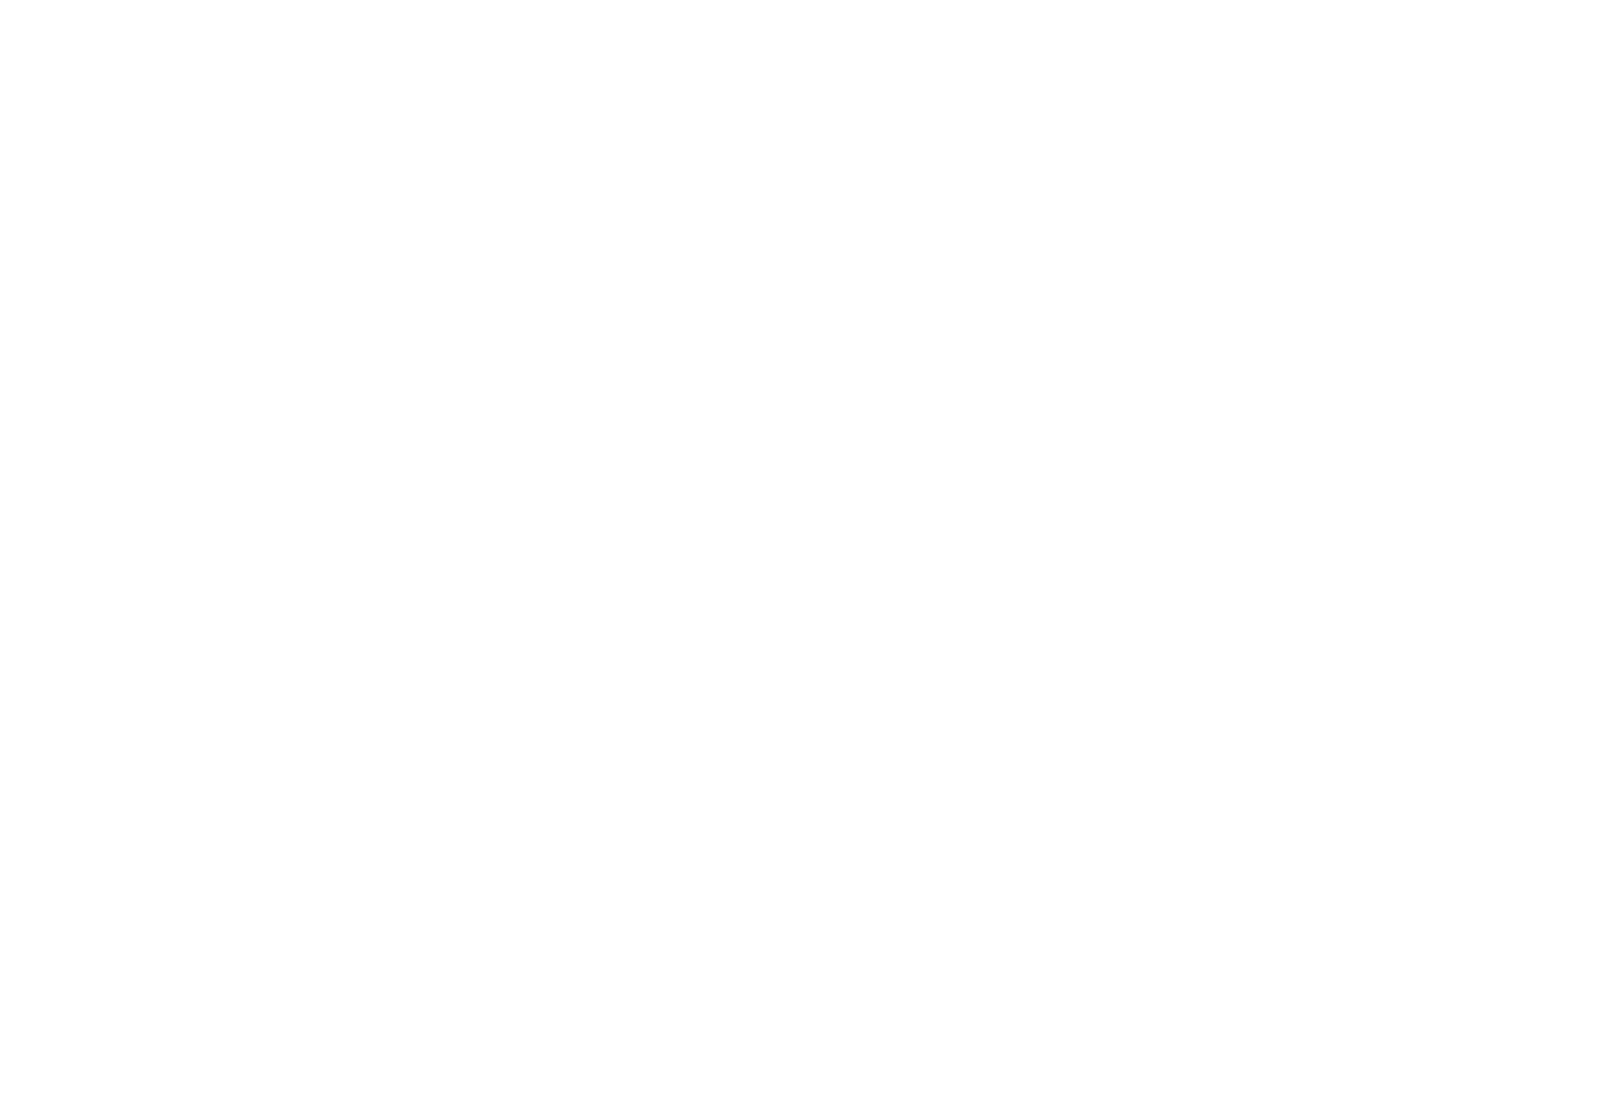

<IPython.core.display.Javascript object>


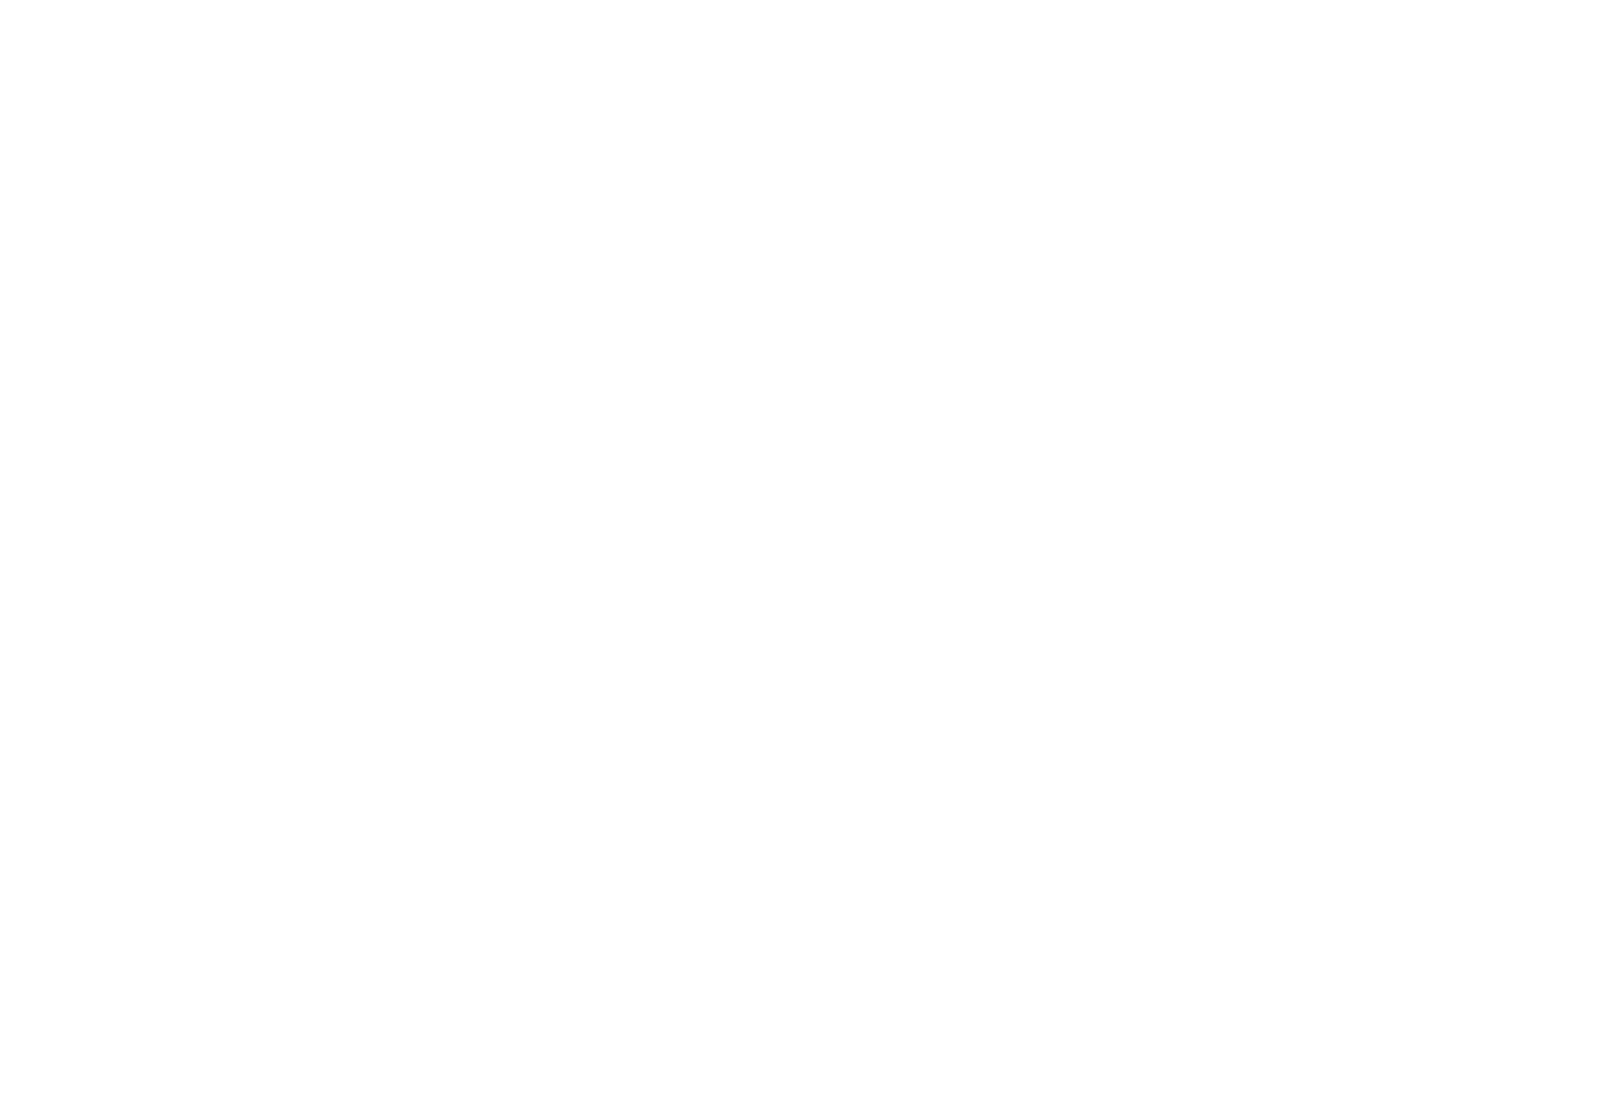

<IPython.core.display.Javascript object>


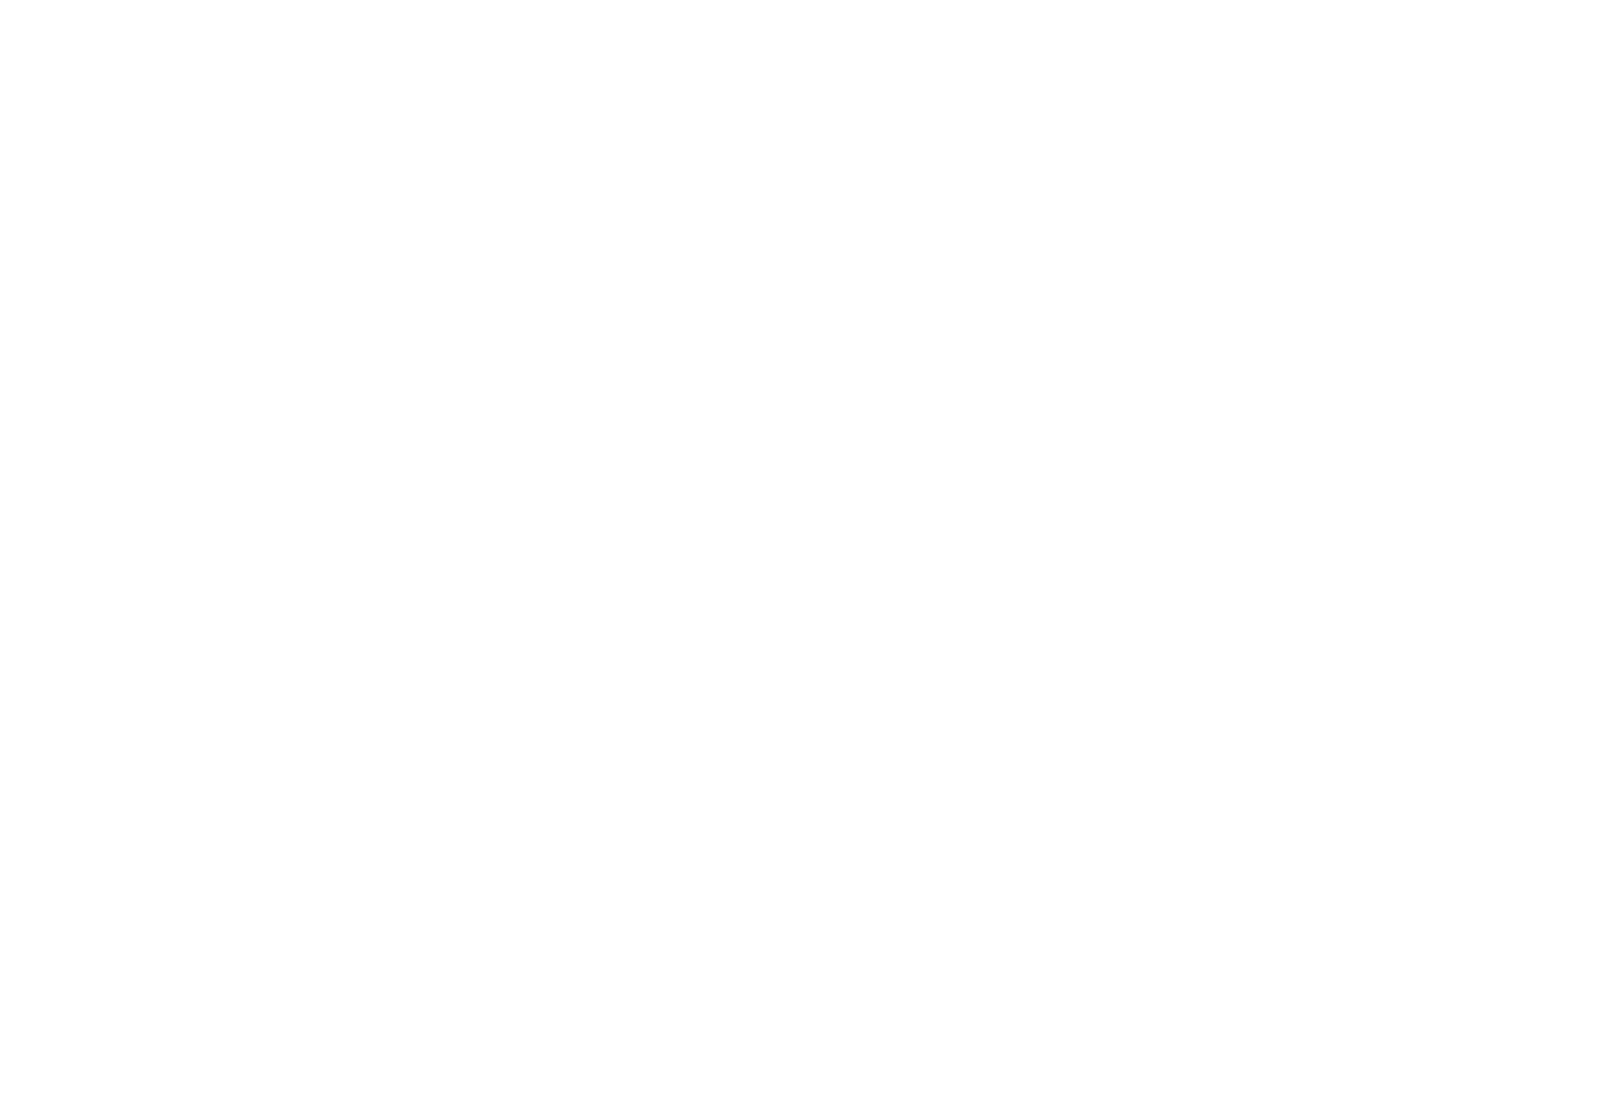

<IPython.core.display.Javascript object>


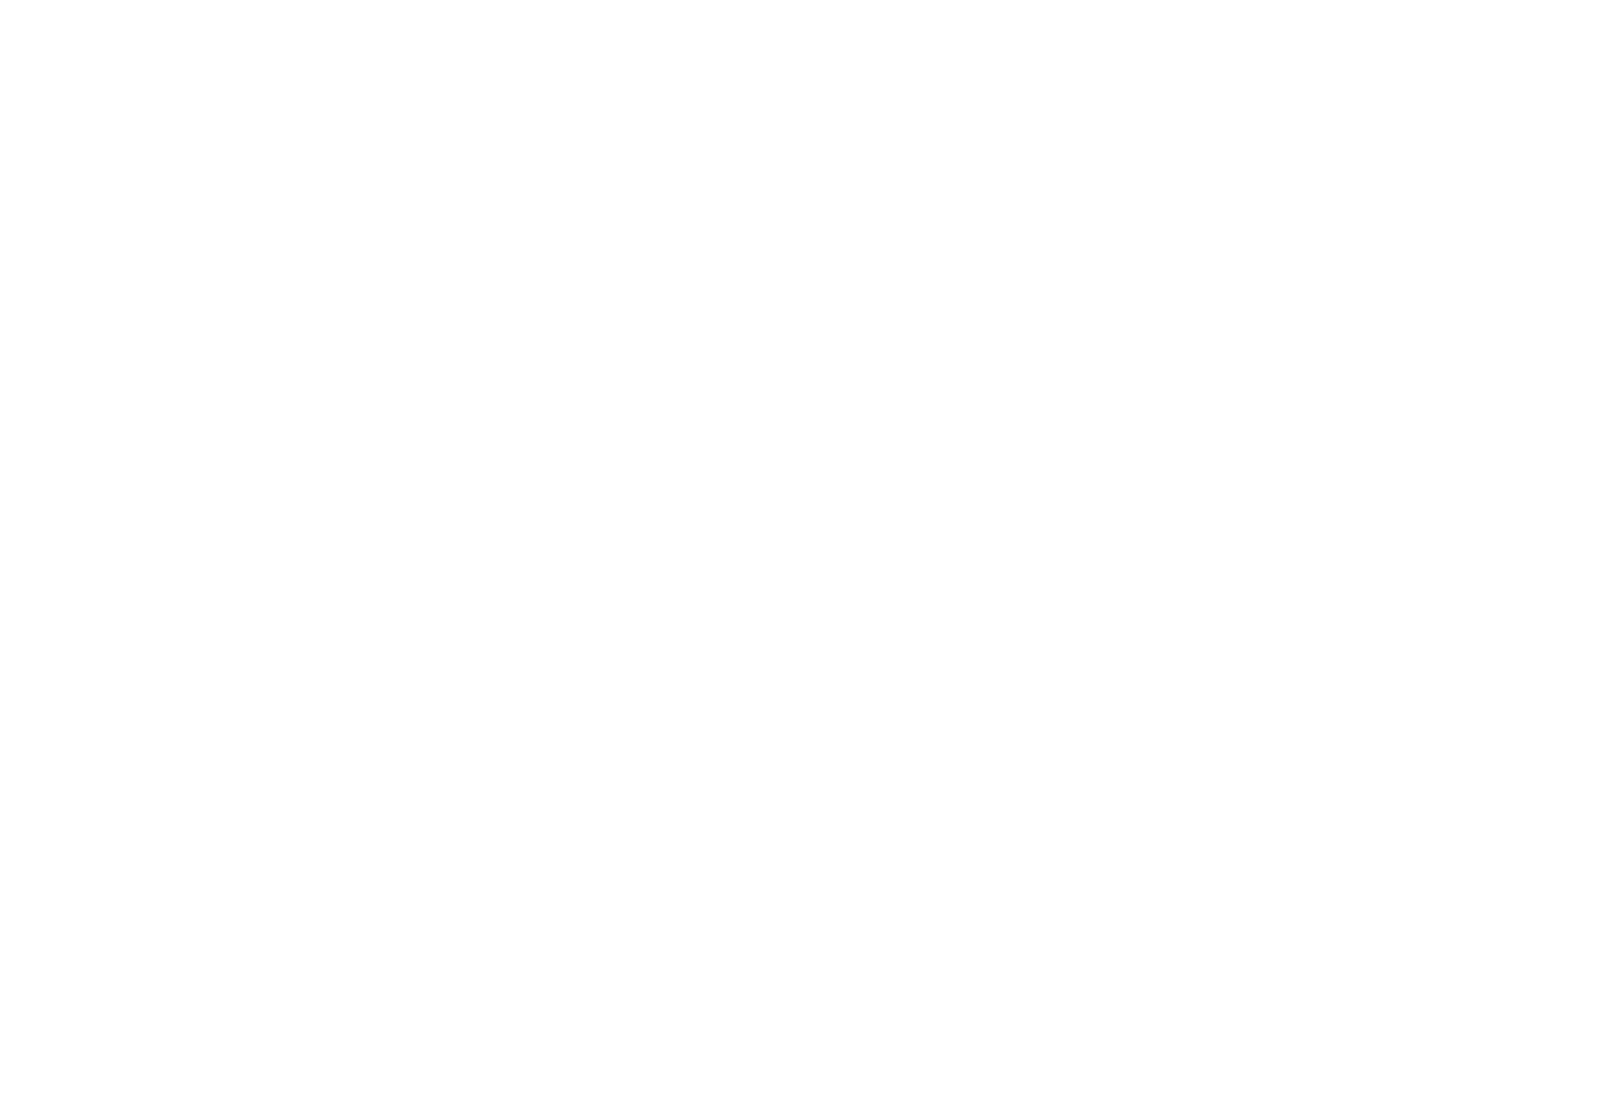

<IPython.core.display.Javascript object>


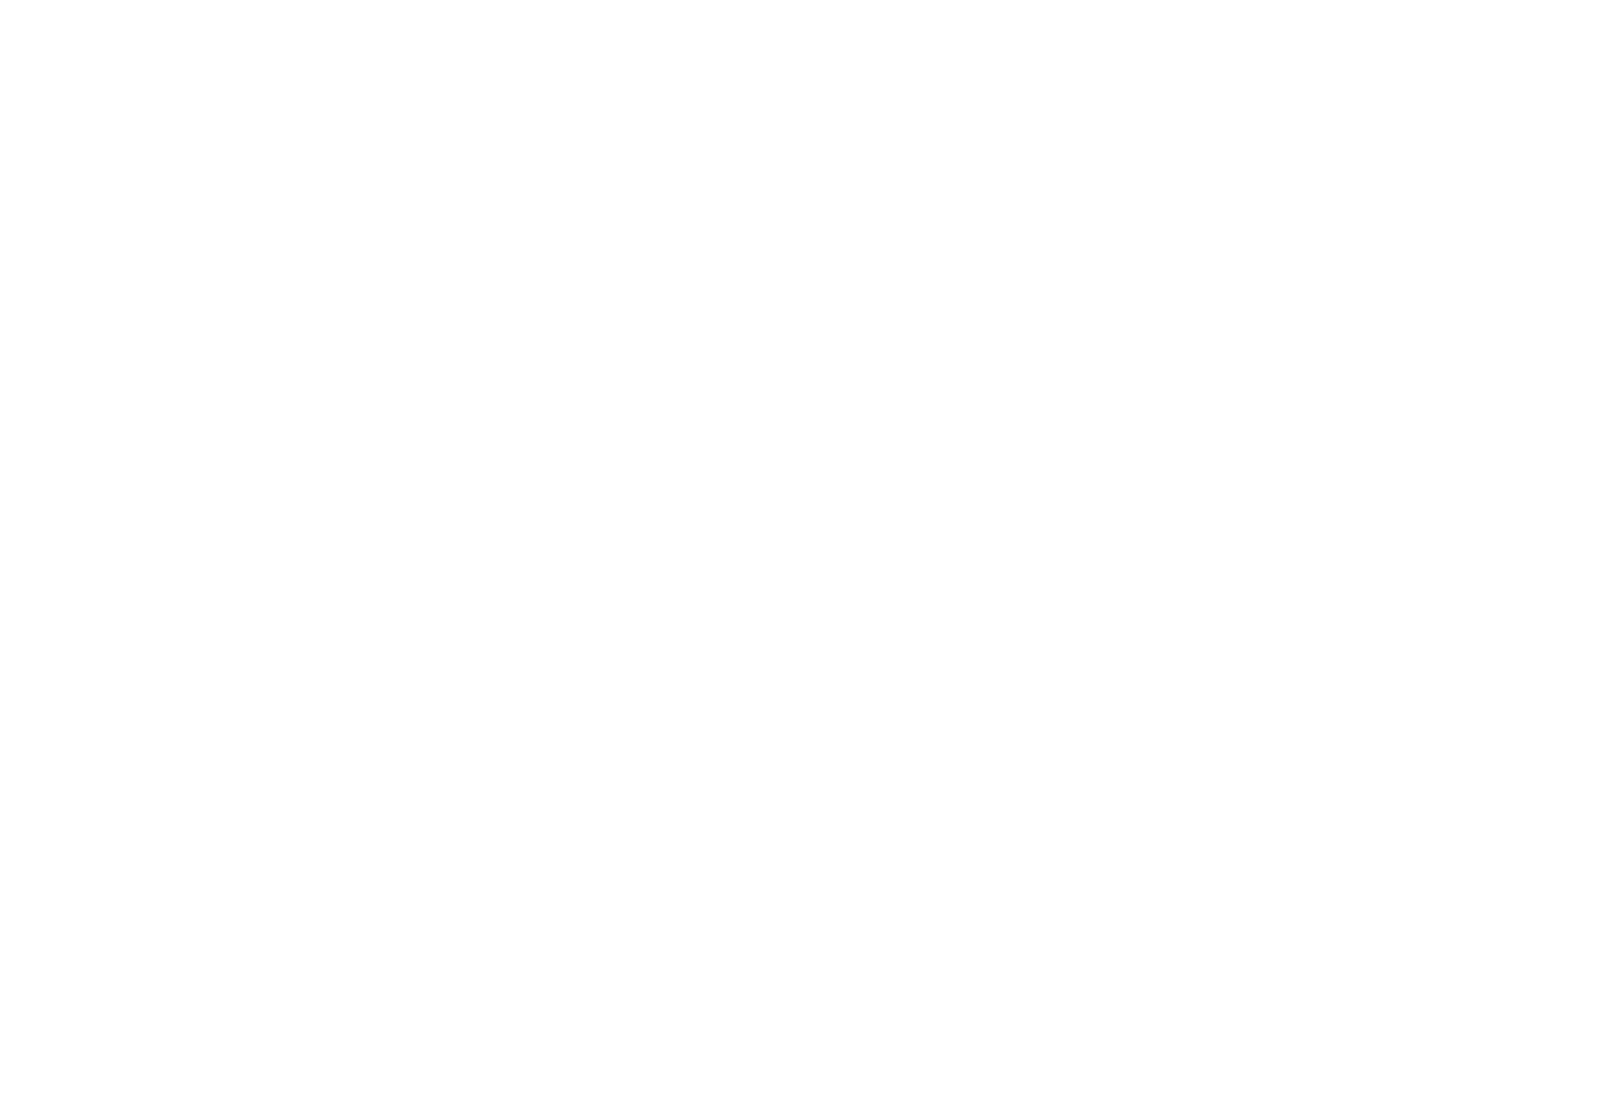

<IPython.core.display.Javascript object>


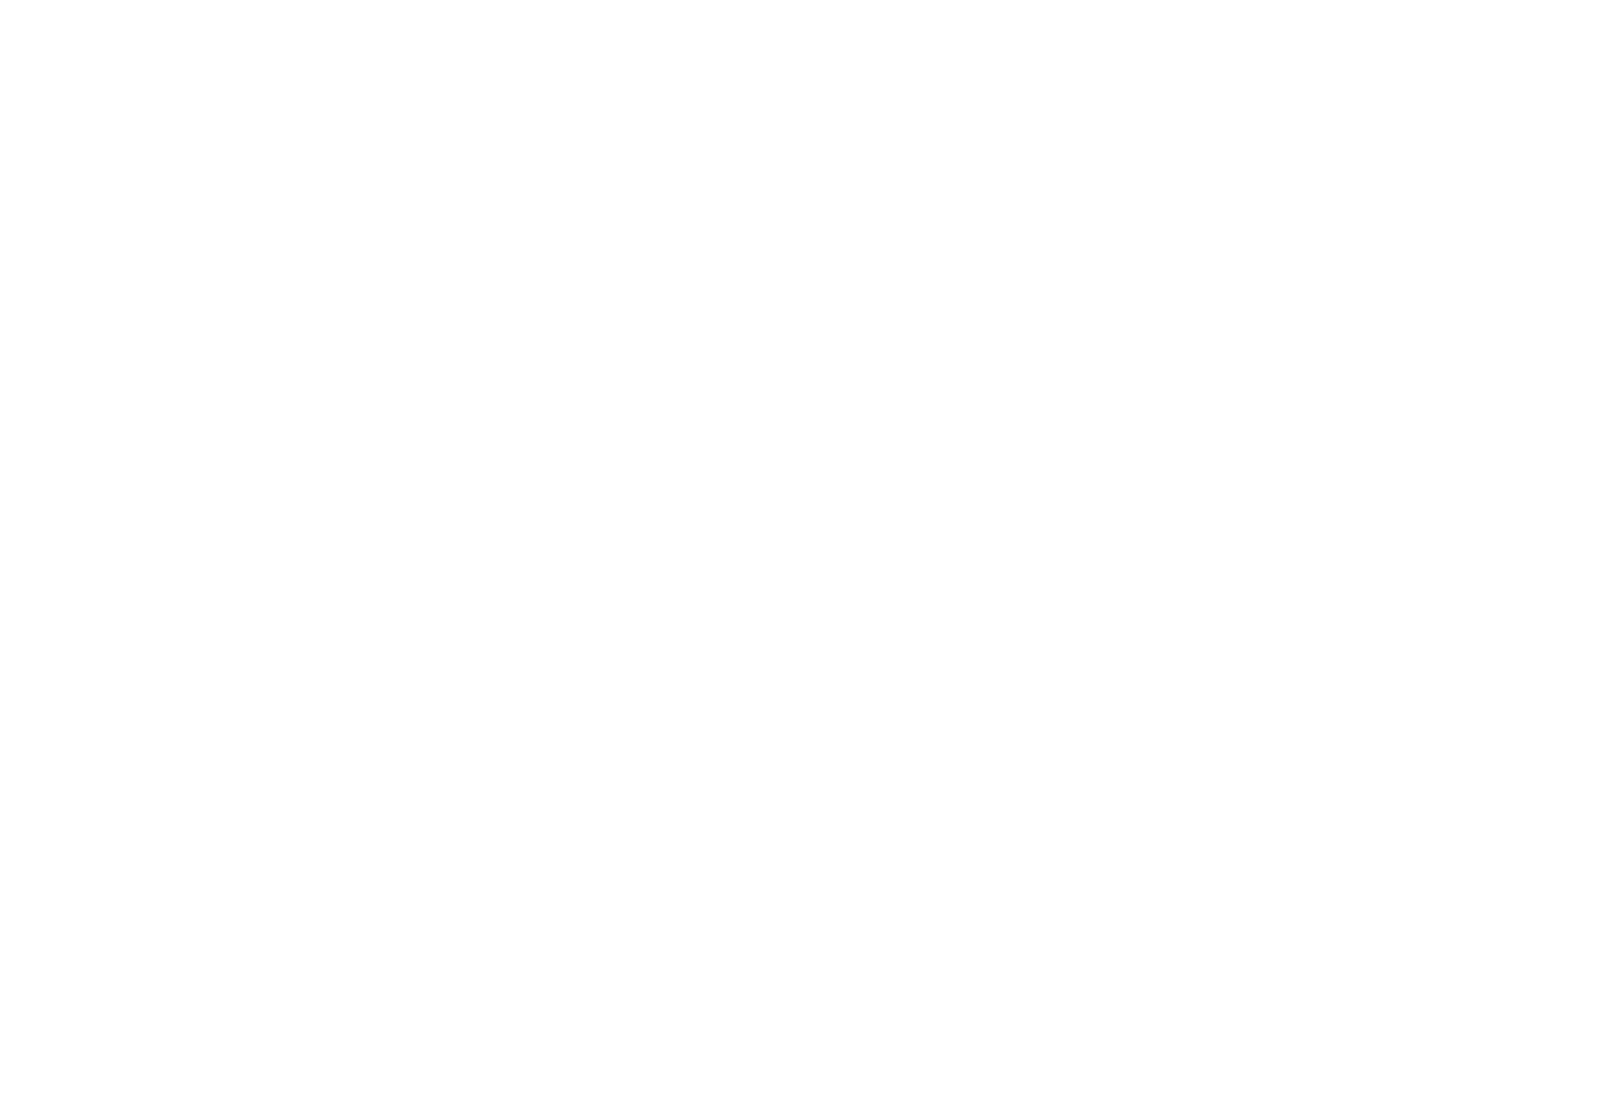

<IPython.core.display.Javascript object>


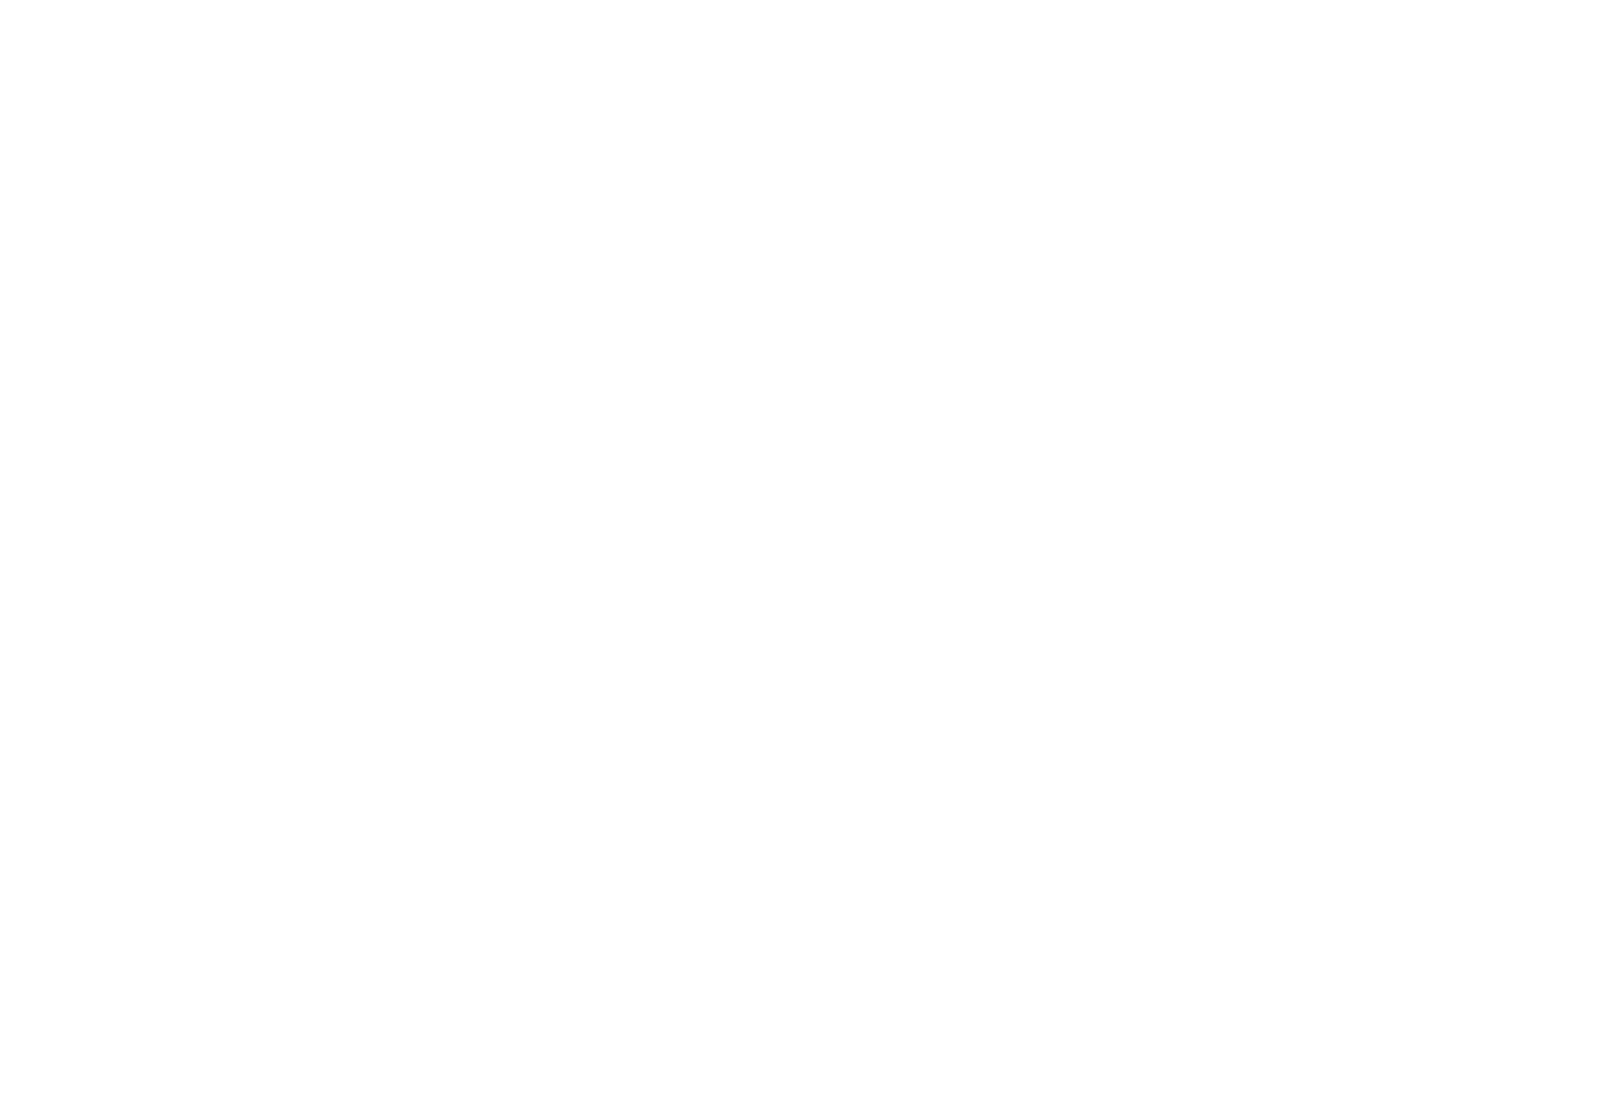

<IPython.core.display.Javascript object>


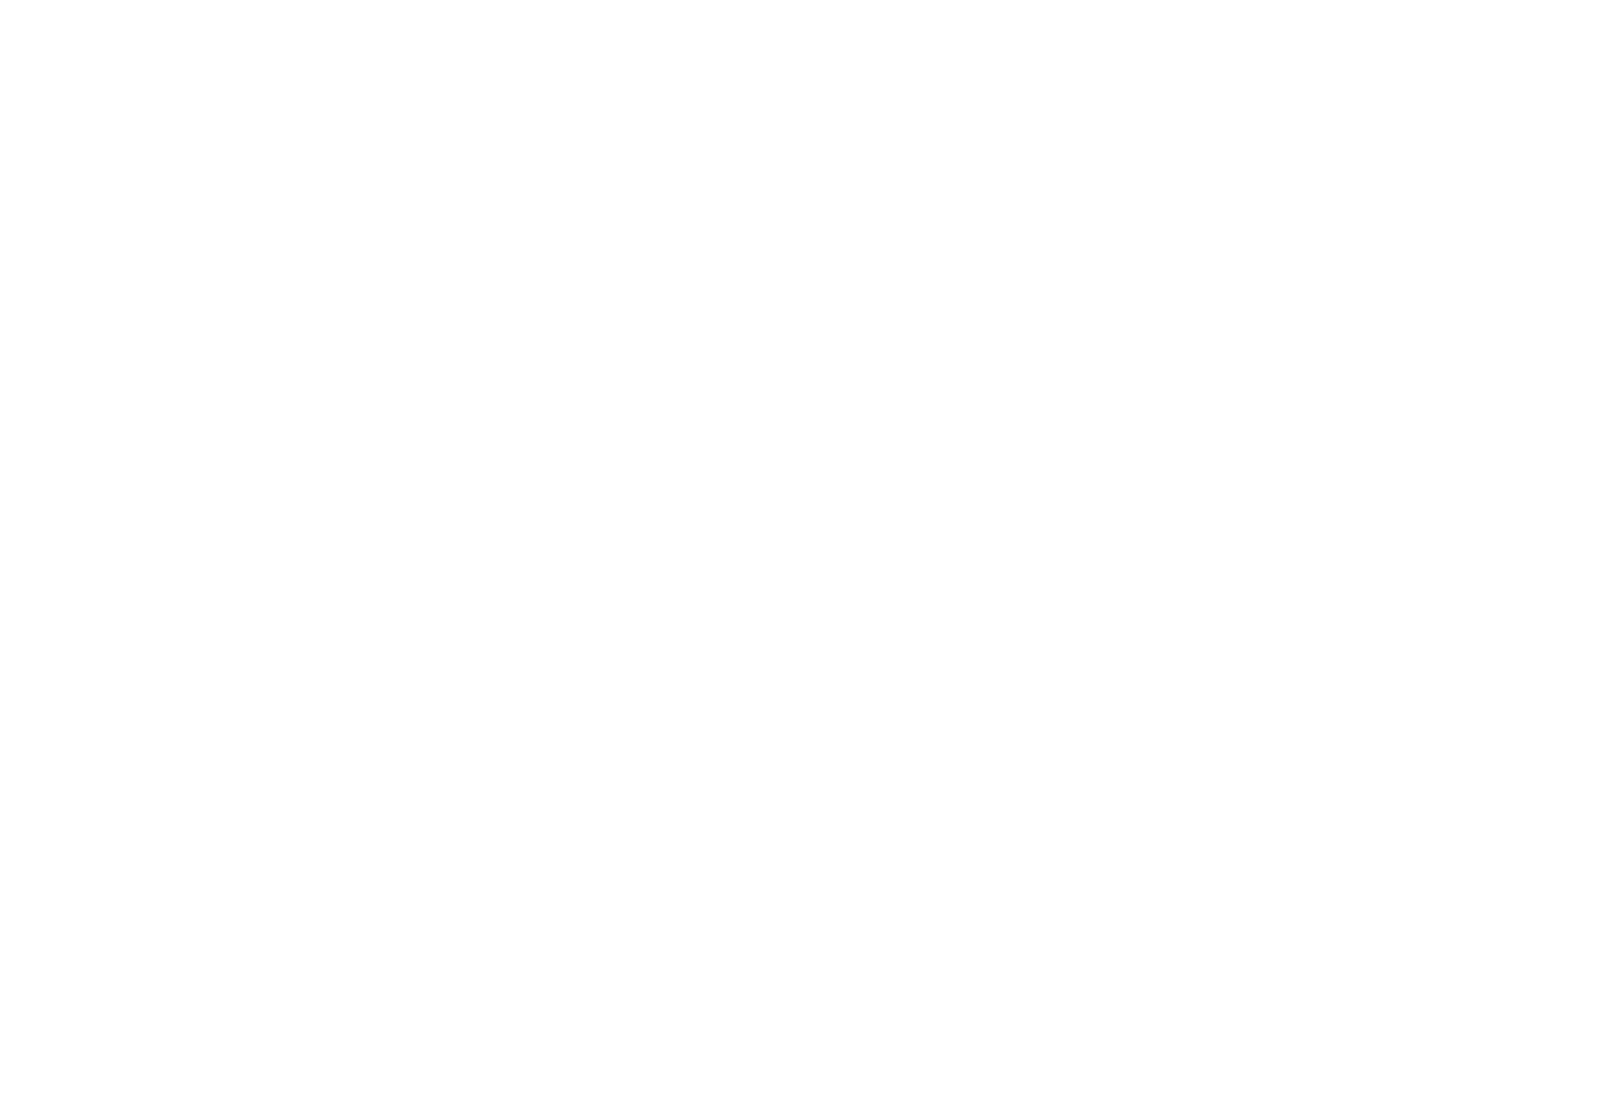

<IPython.core.display.Javascript object>


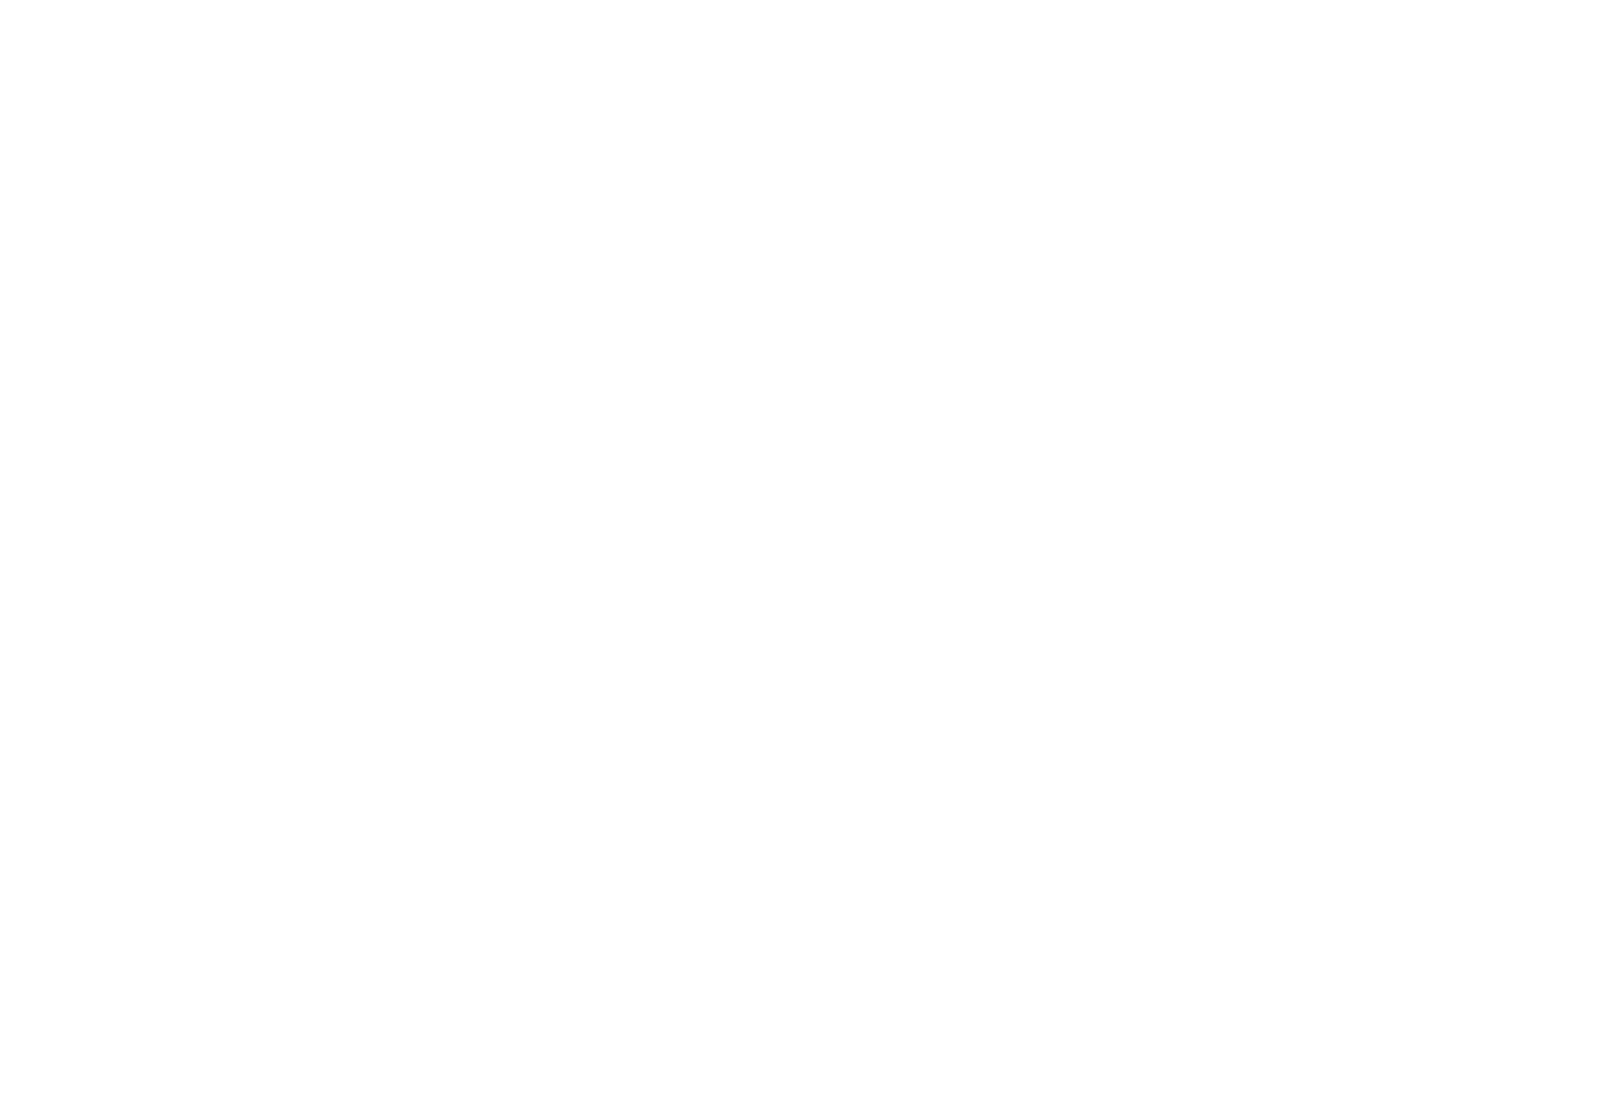

<IPython.core.display.Javascript object>


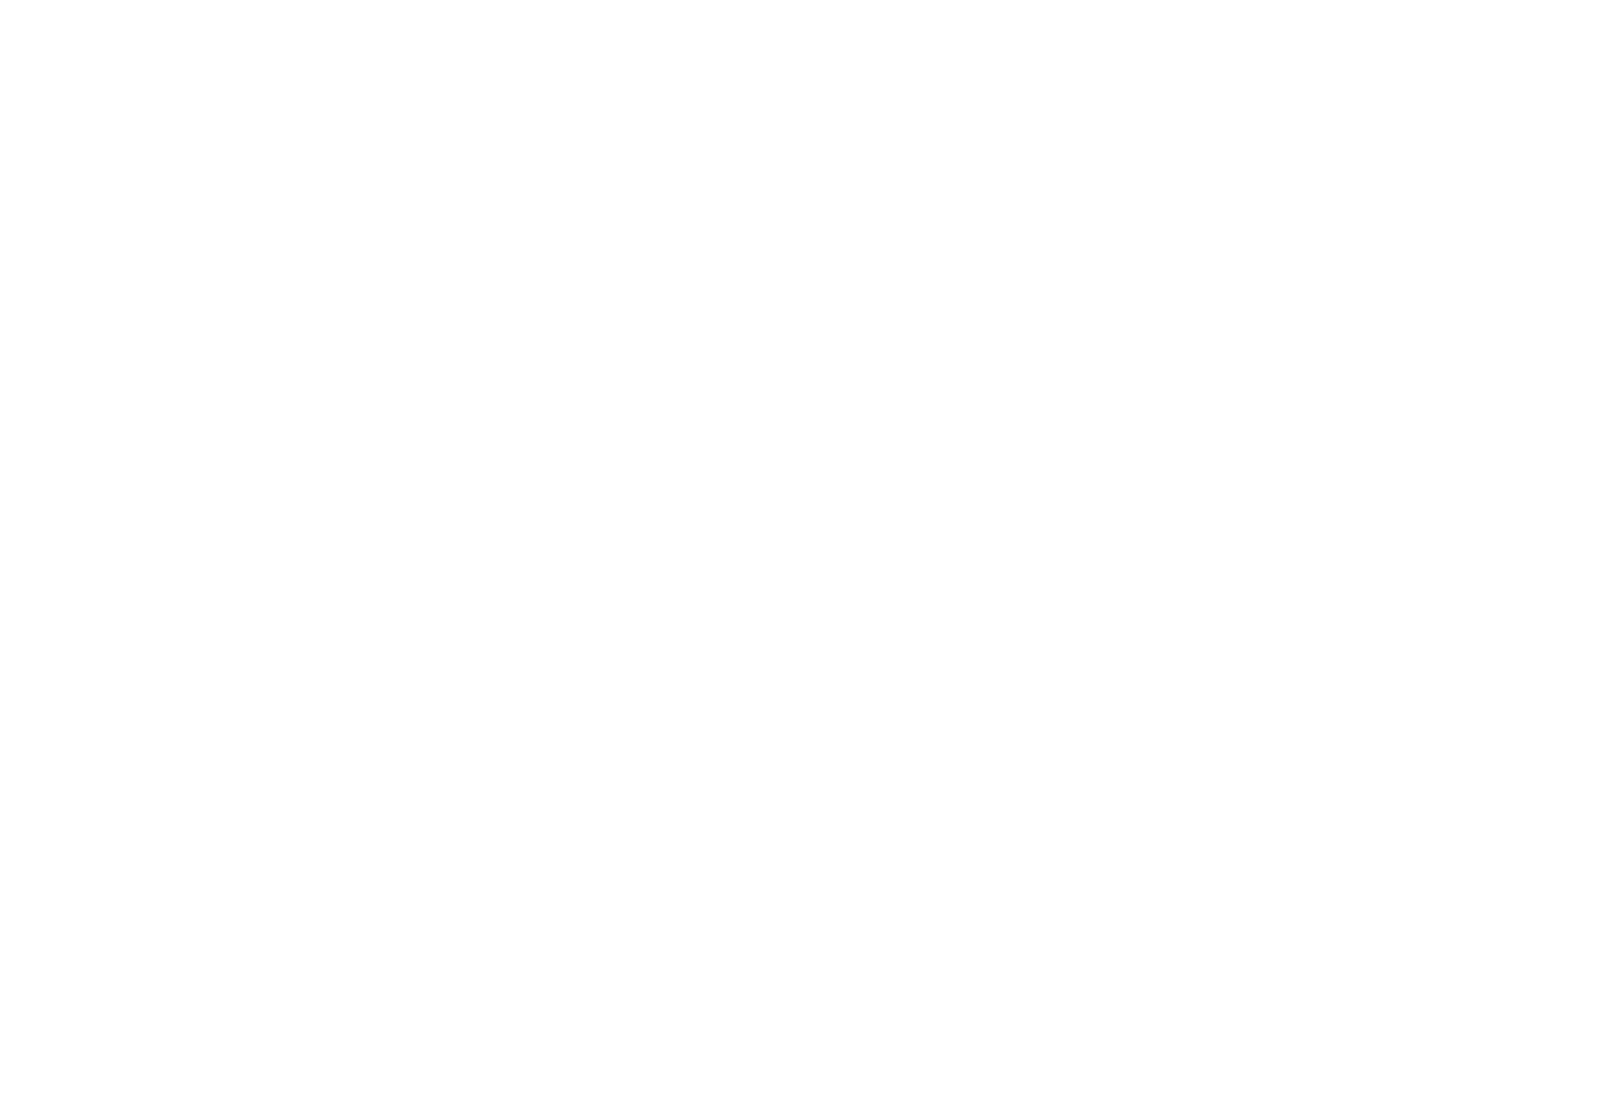

<IPython.core.display.Javascript object>


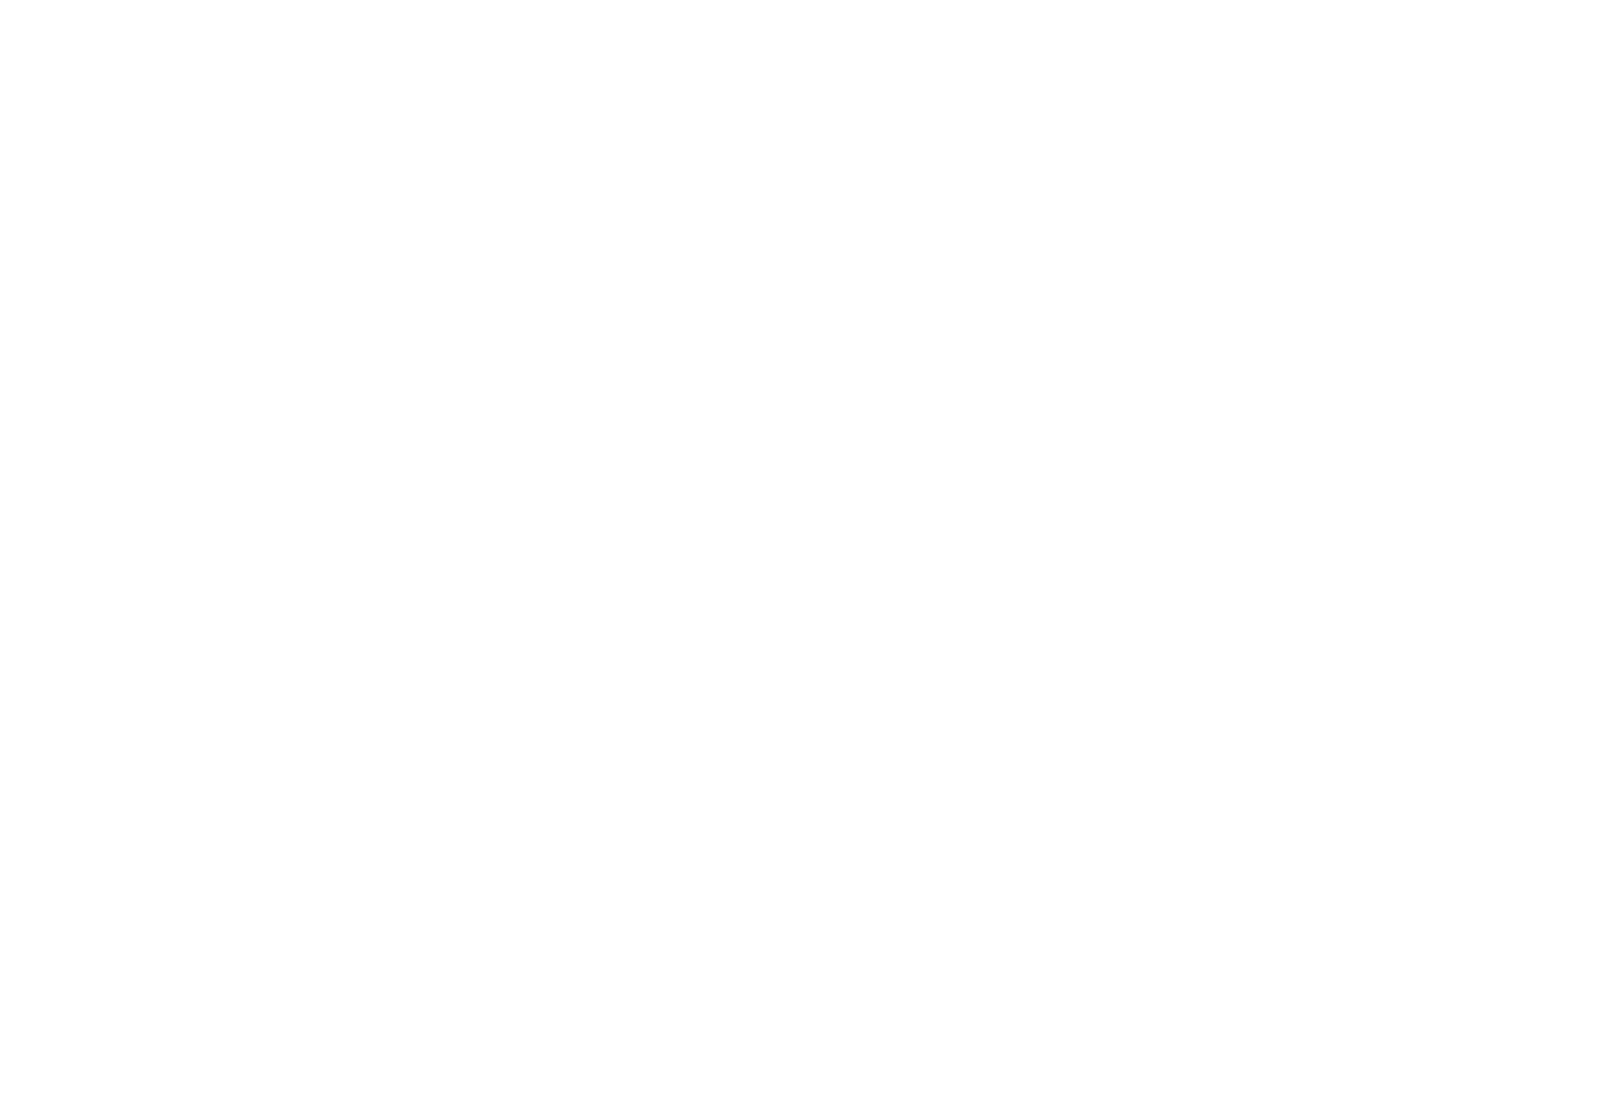

<IPython.core.display.Javascript object>


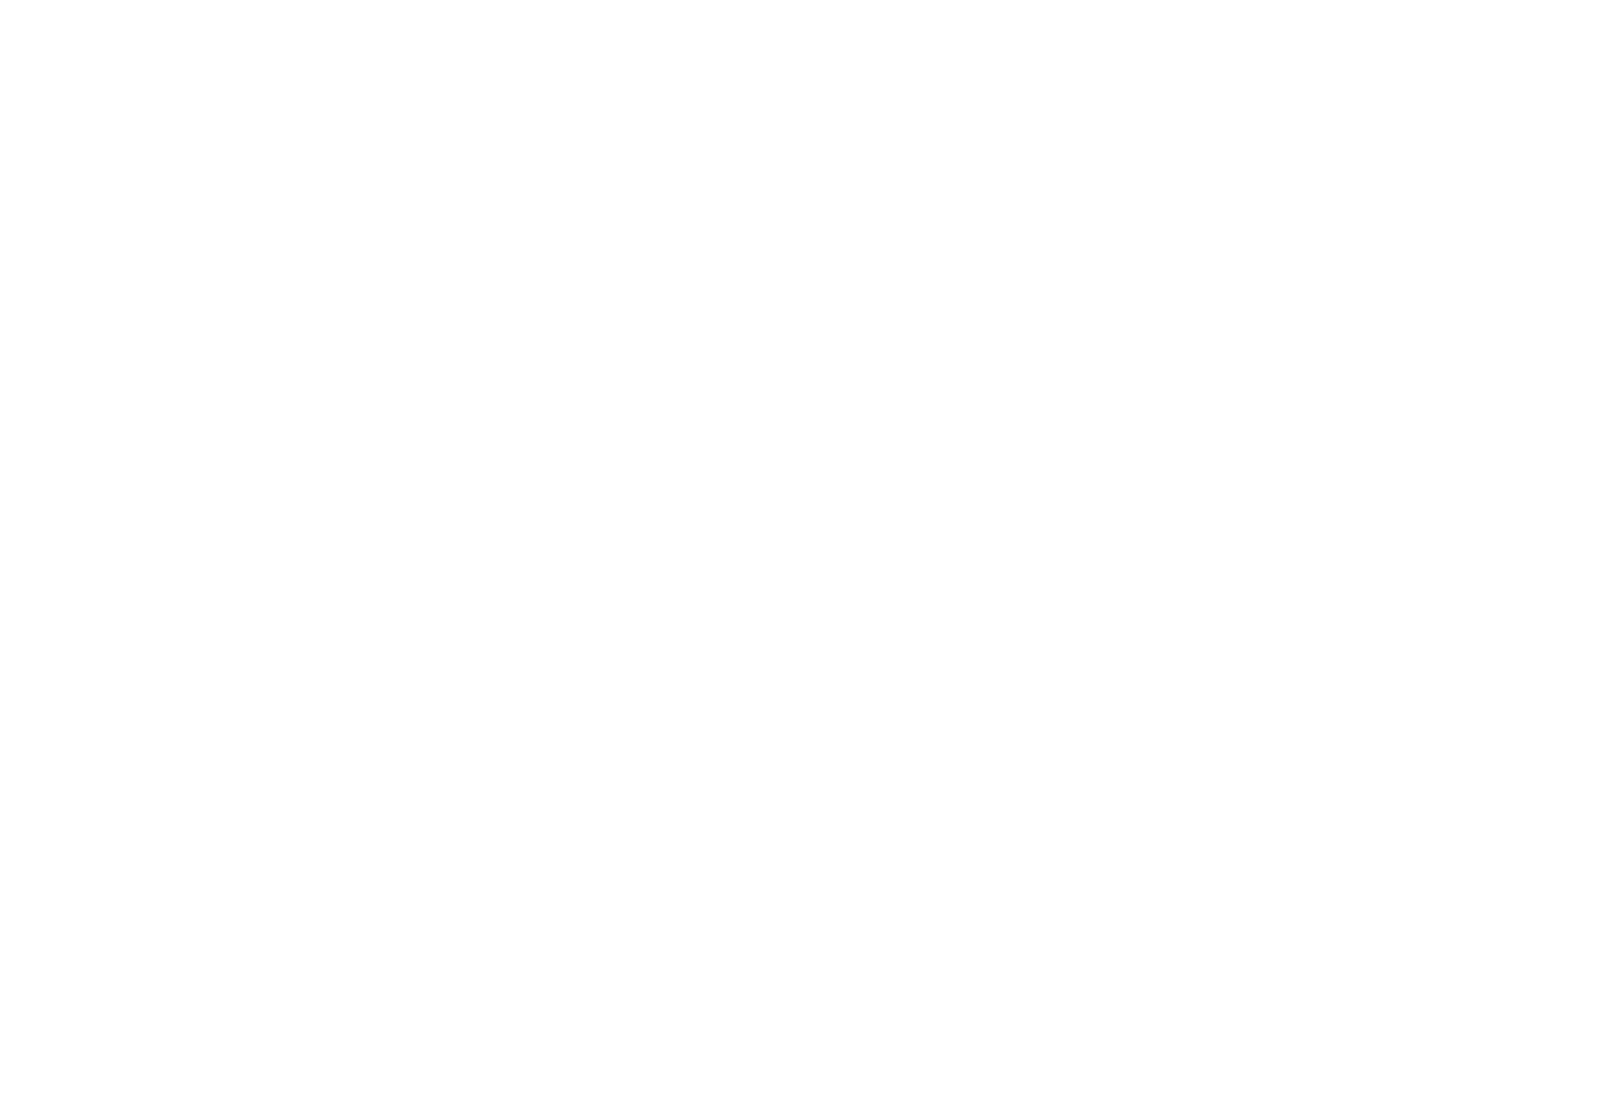

<IPython.core.display.Javascript object>


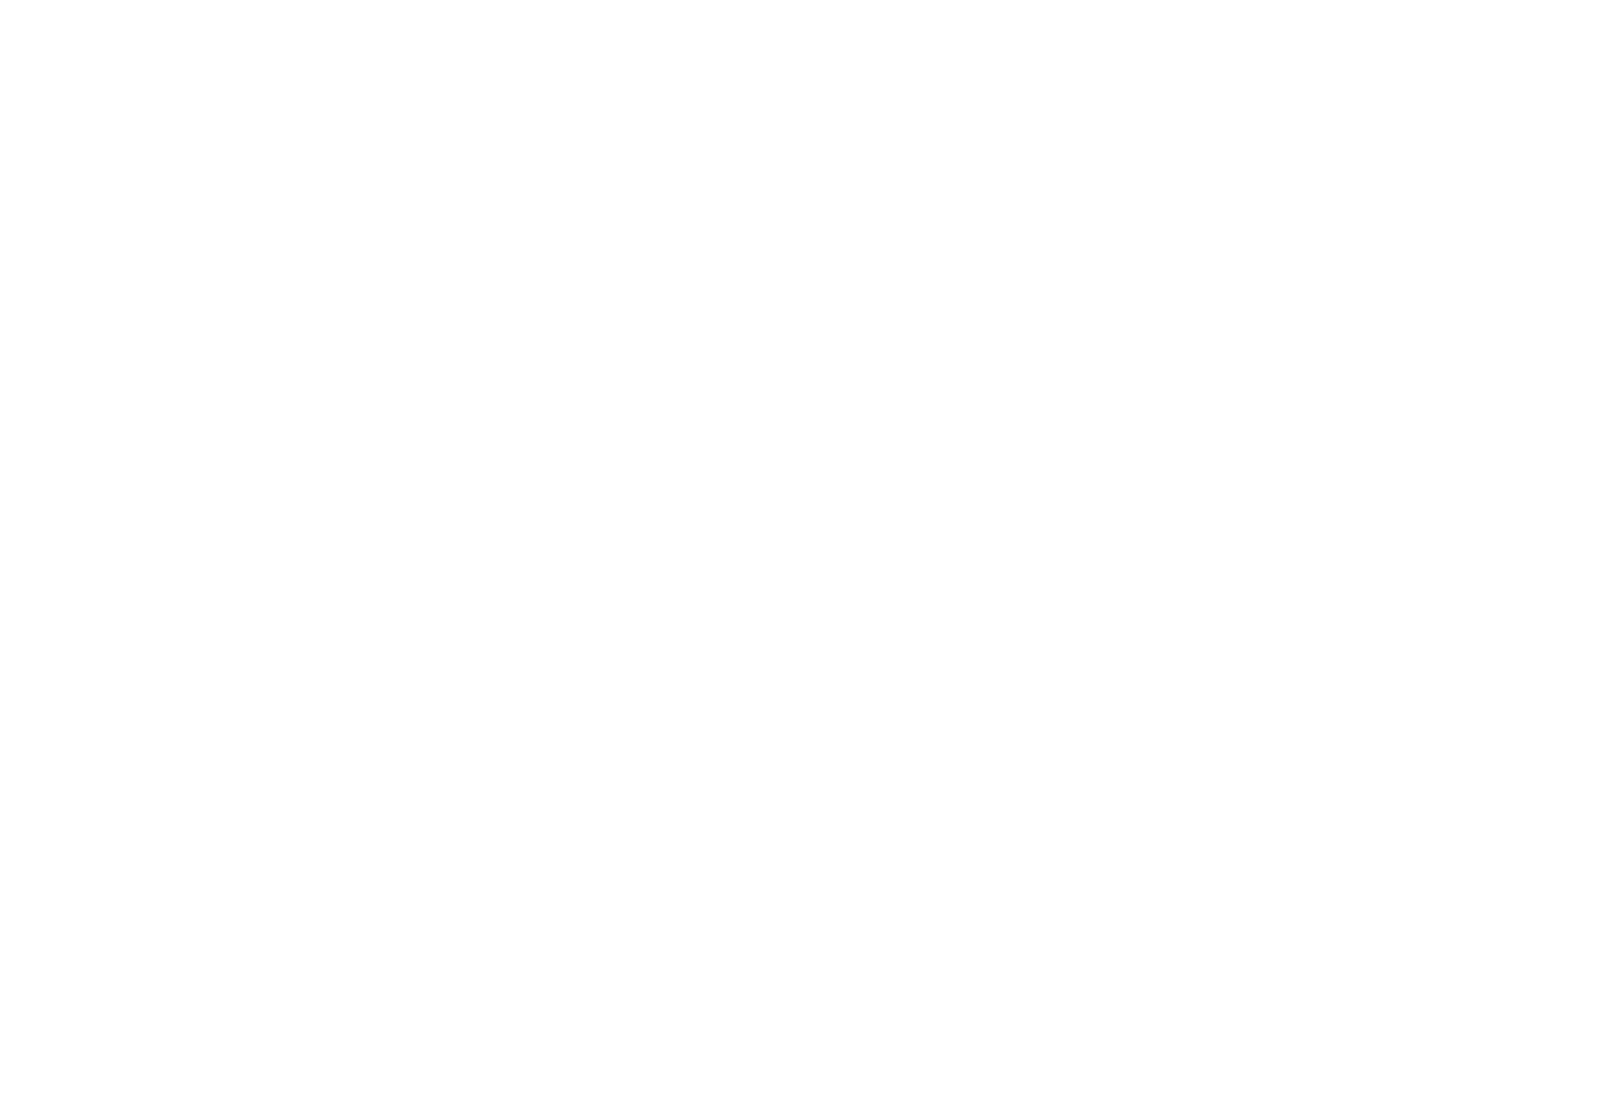

<IPython.core.display.Javascript object>


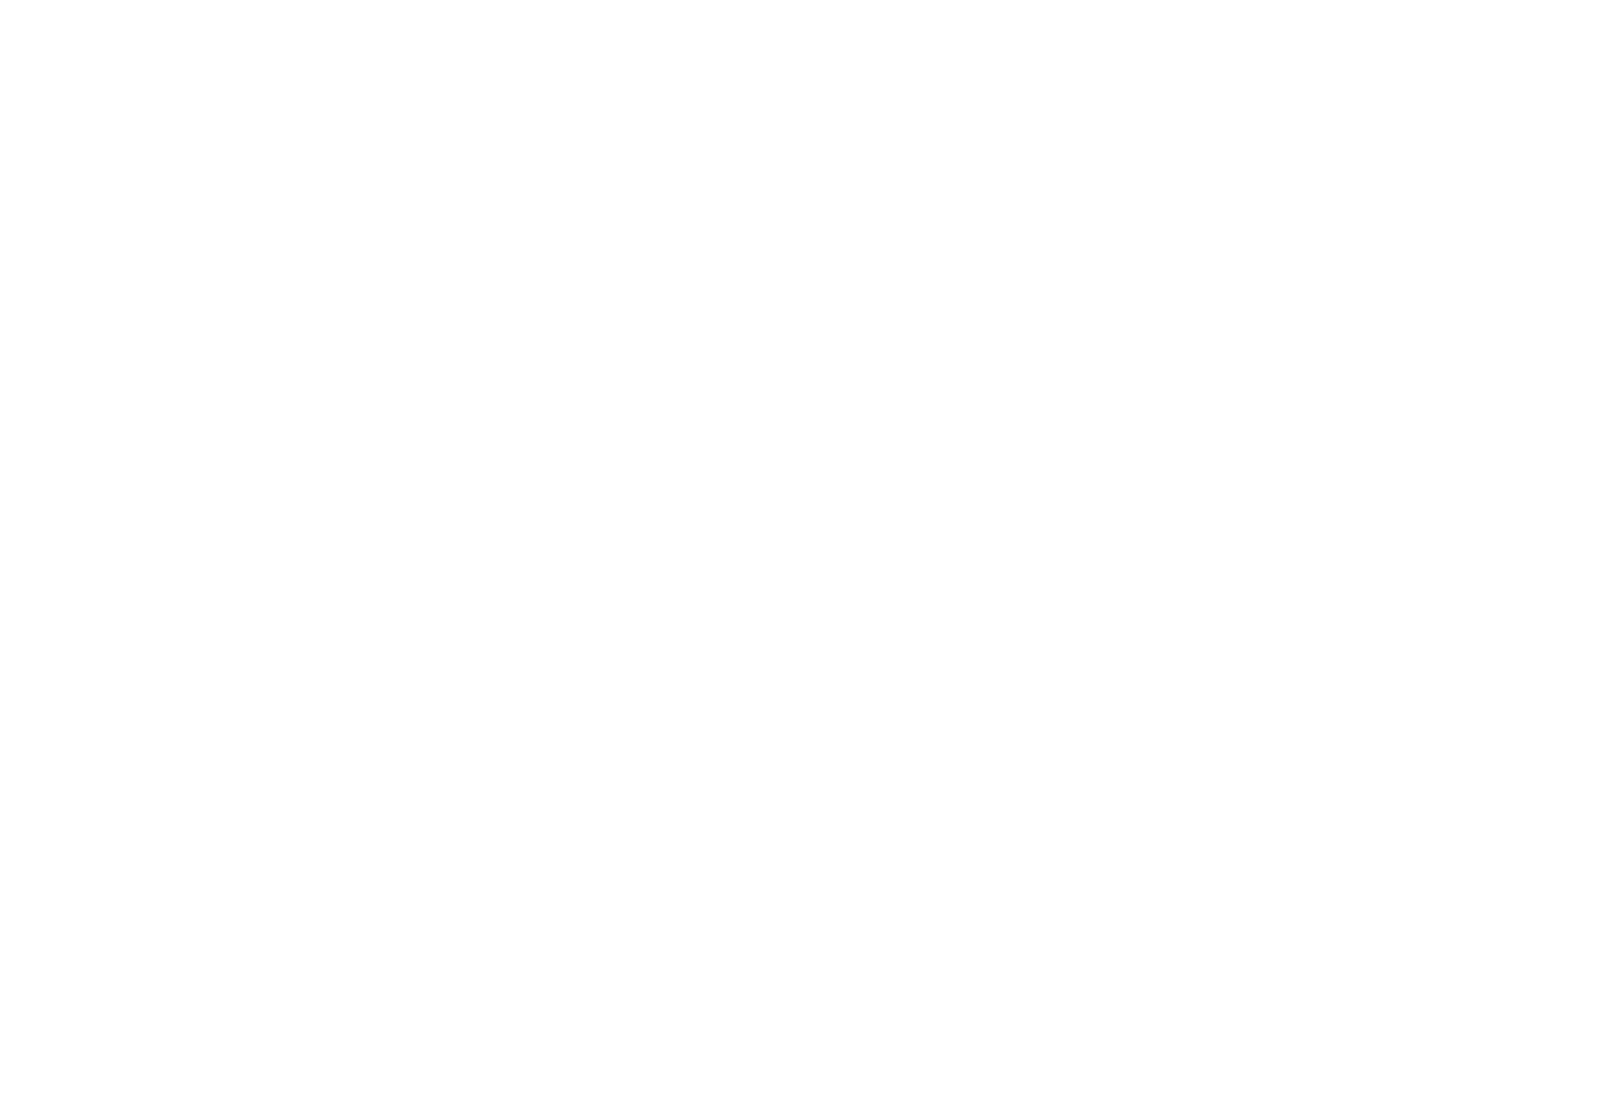

<IPython.core.display.Javascript object>


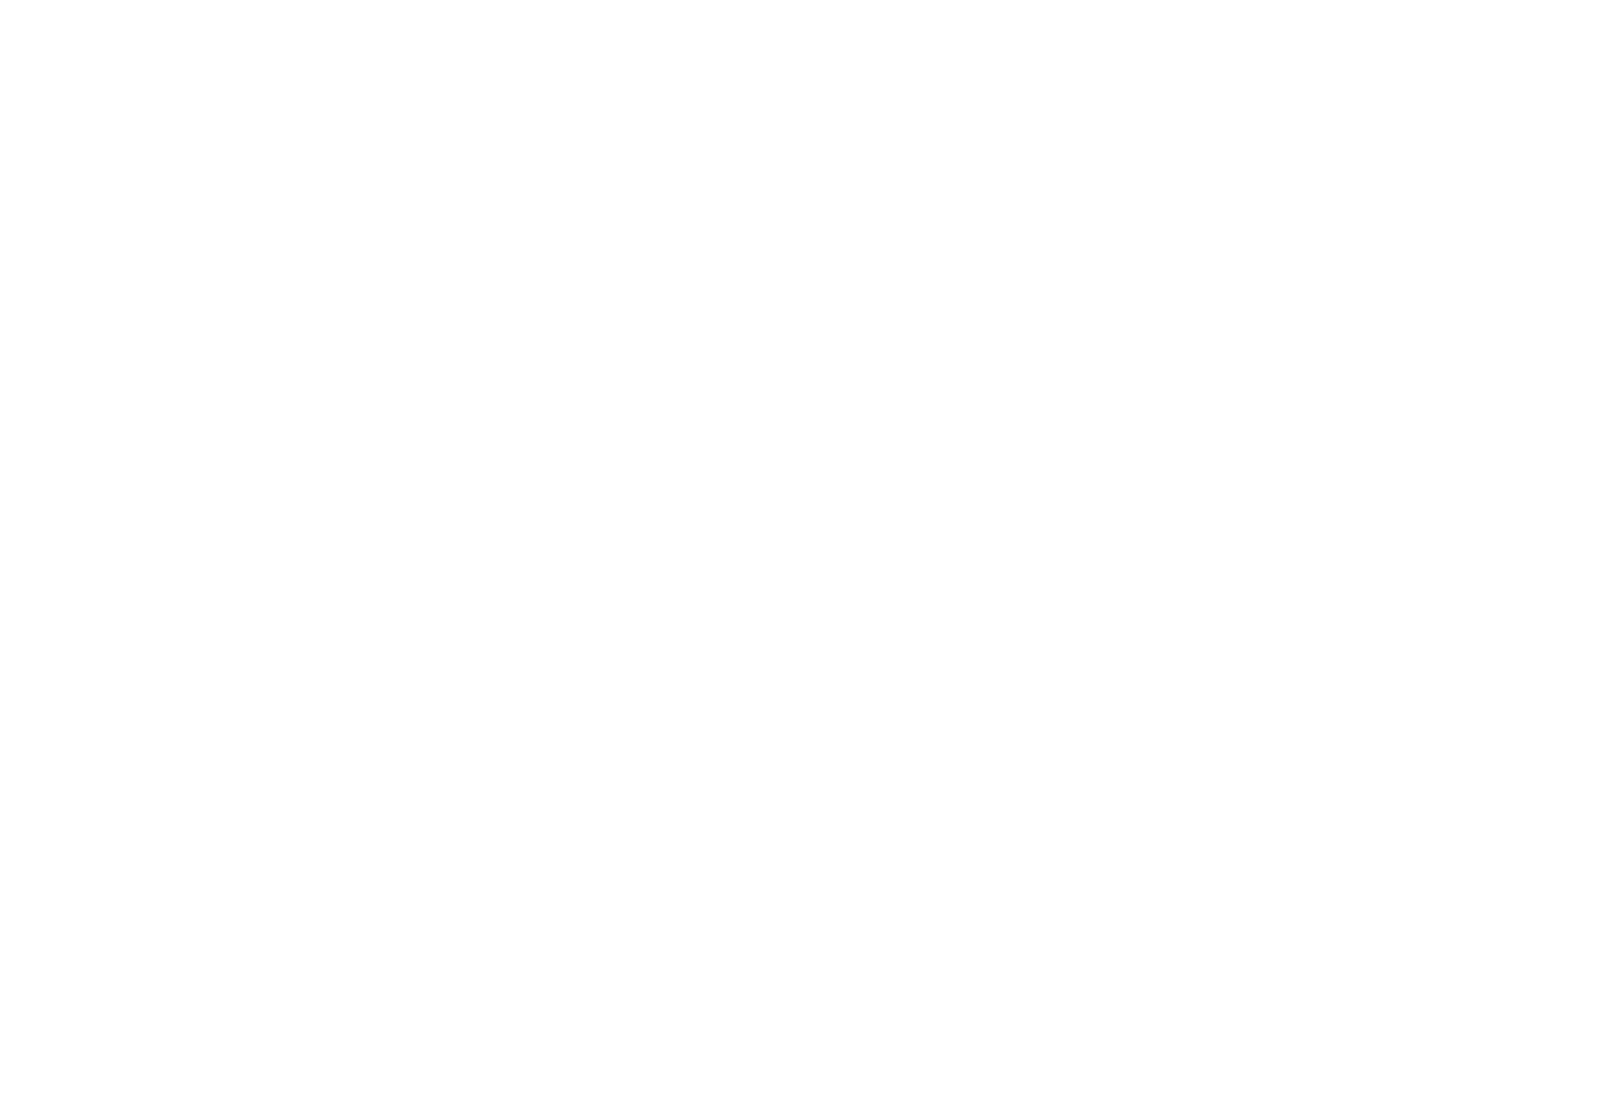

<IPython.core.display.Javascript object>


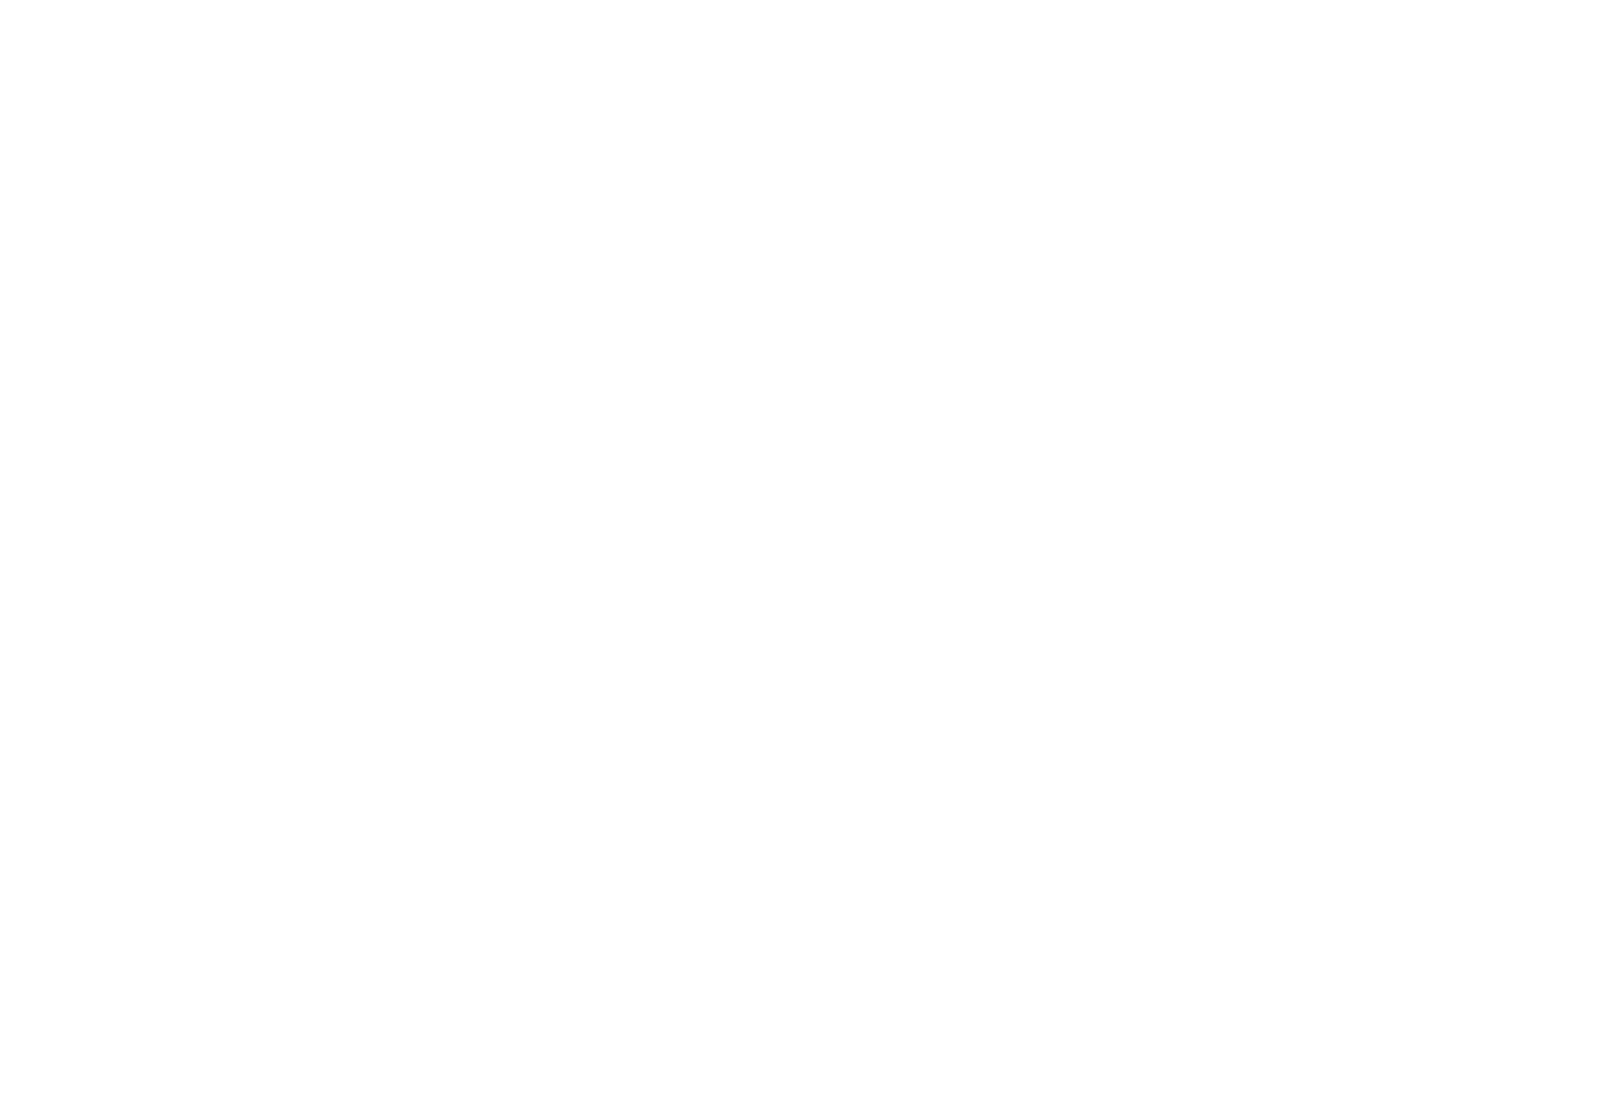

<IPython.core.display.Javascript object>


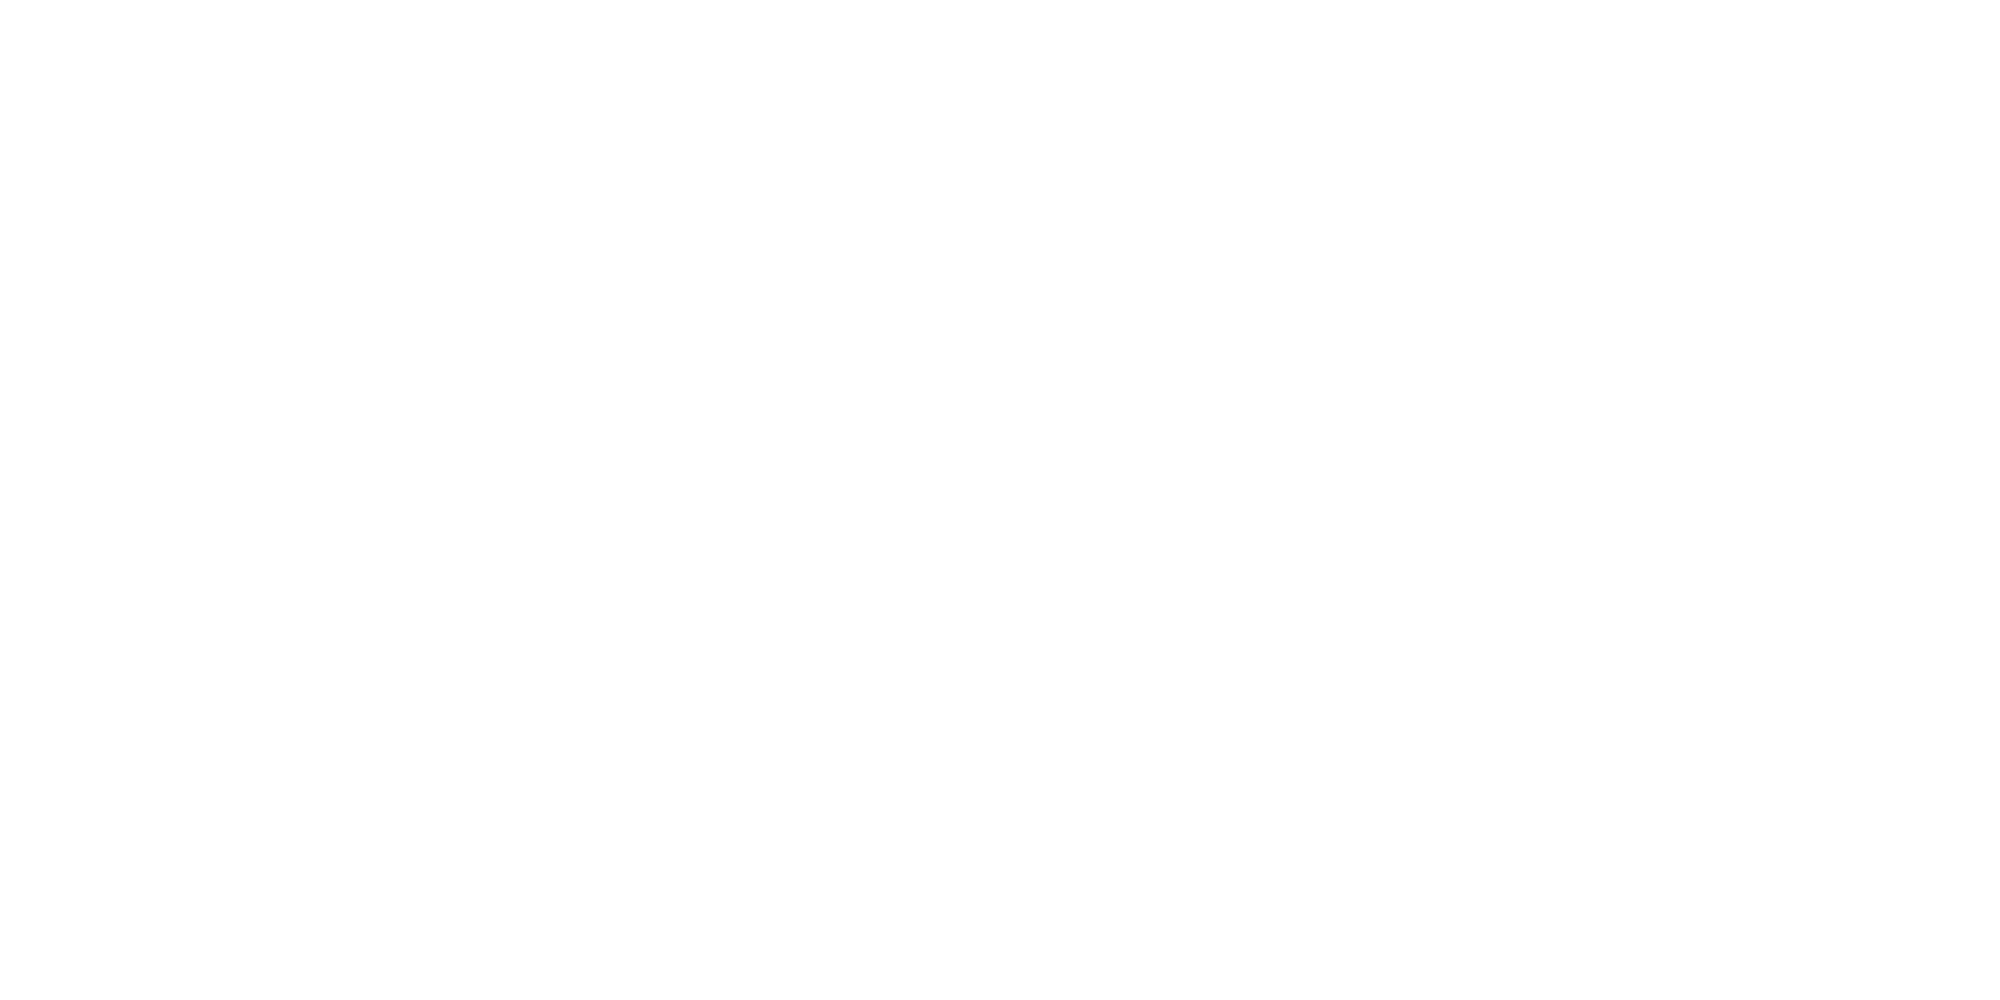

<IPython.core.display.Javascript object>


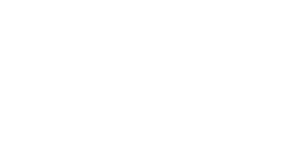

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


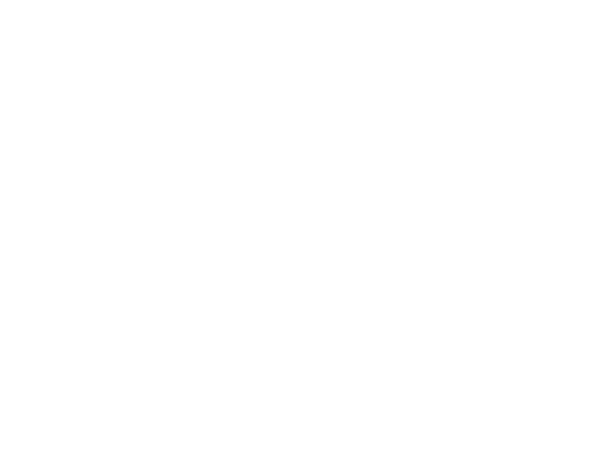

<IPython.core.display.Javascript object>


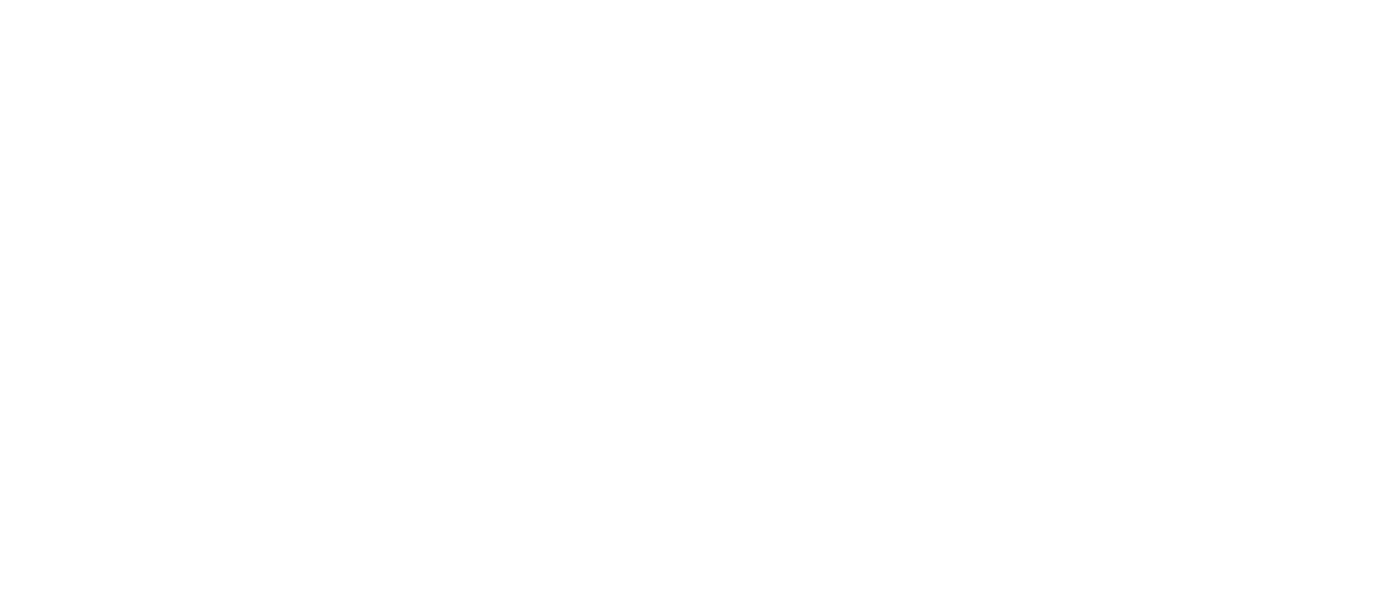

<IPython.core.display.Javascript object>


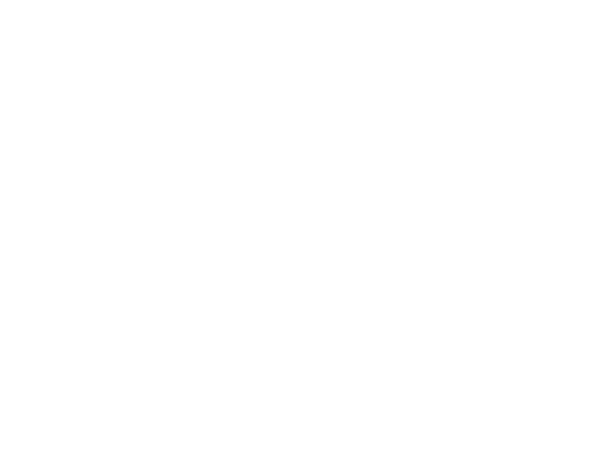

<IPython.core.display.Javascript object>


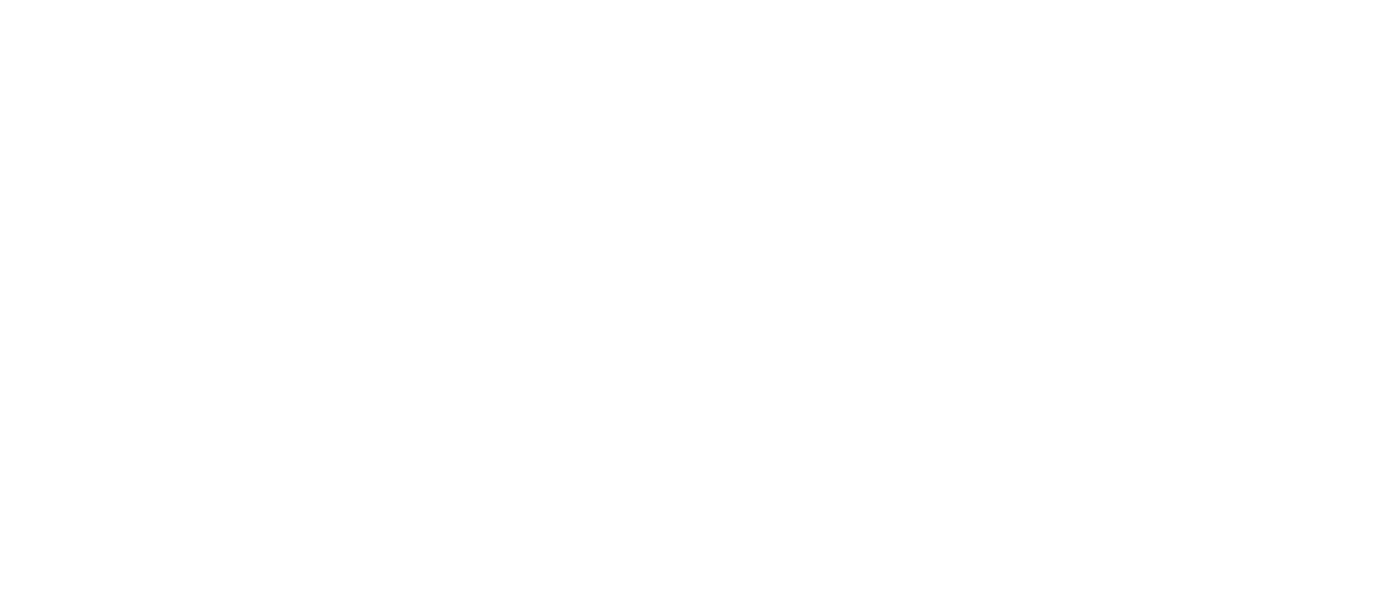

<IPython.core.display.Javascript object>


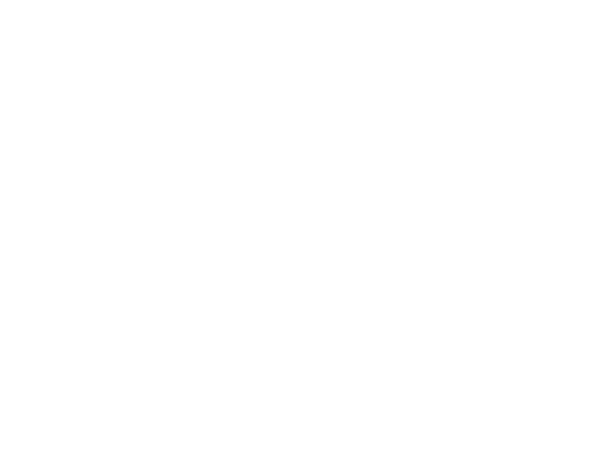

<IPython.core.display.Javascript object>


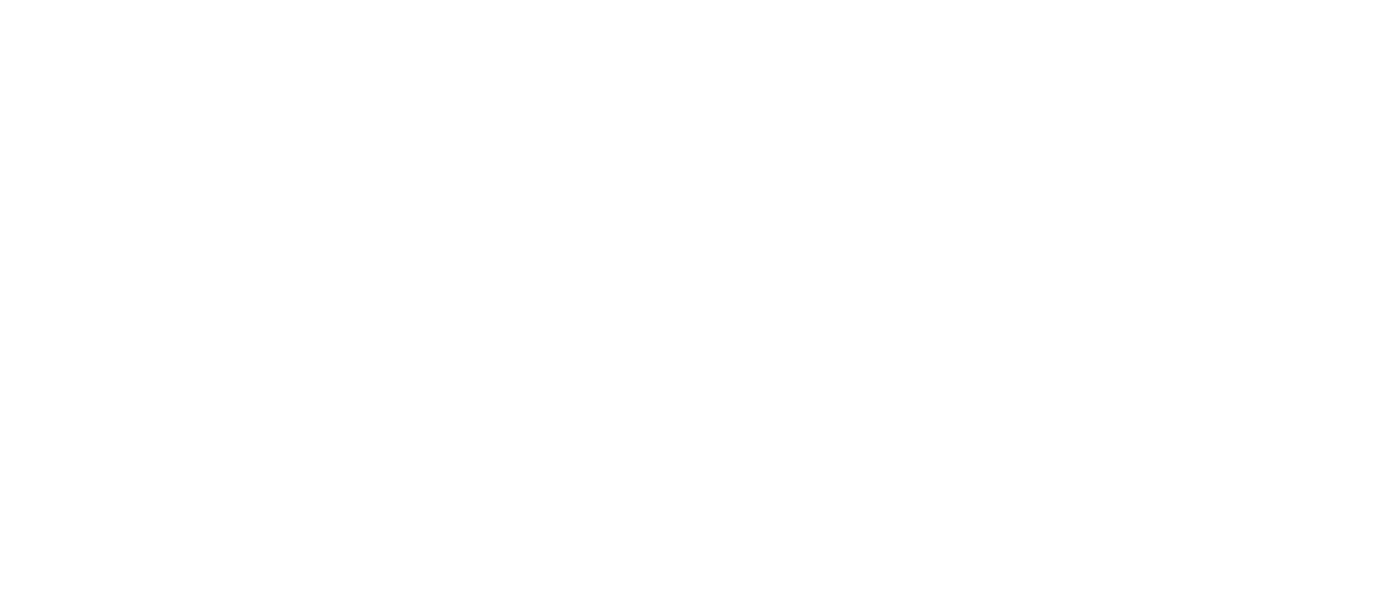

<IPython.core.display.Javascript object>


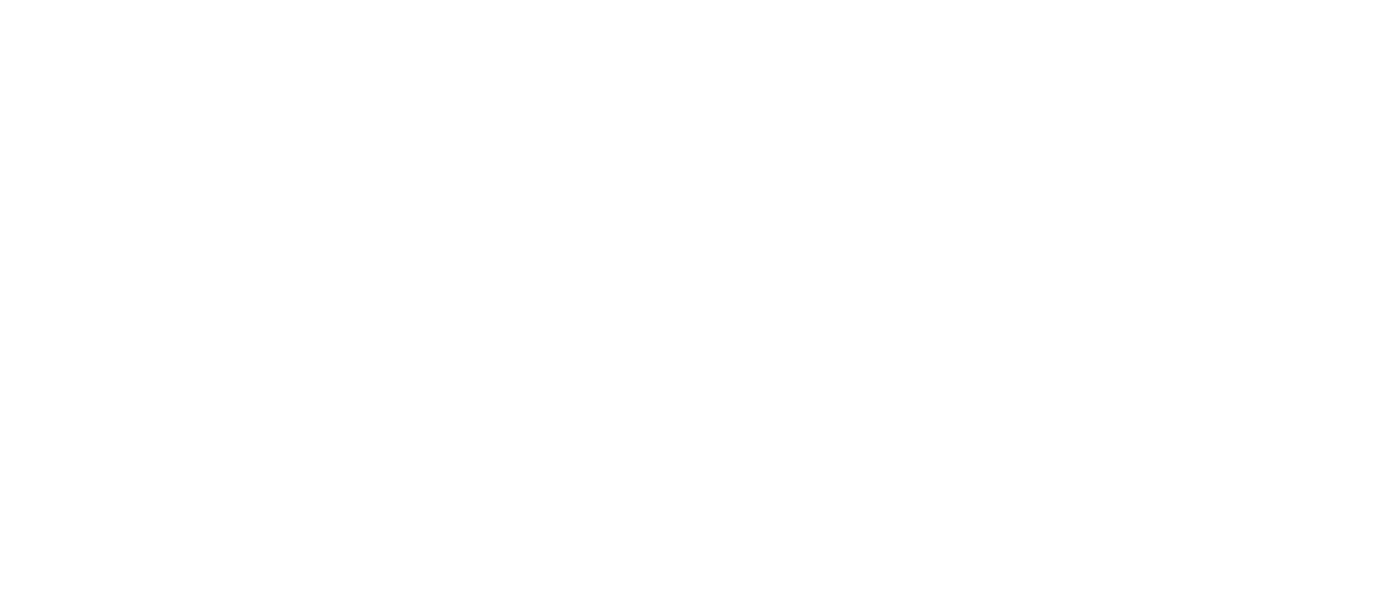

<IPython.core.display.Javascript object>


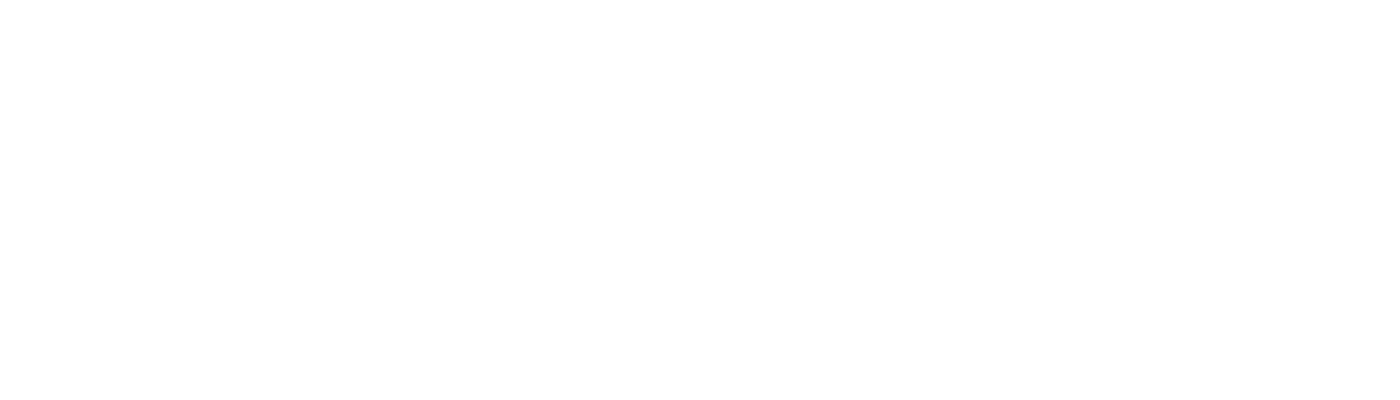

<IPython.core.display.Javascript object>


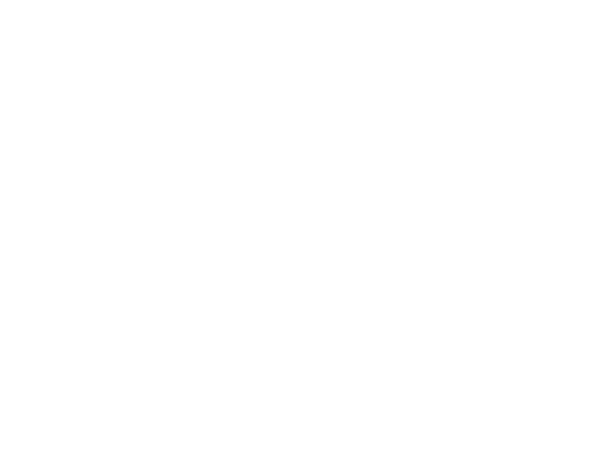

<IPython.core.display.Javascript object>


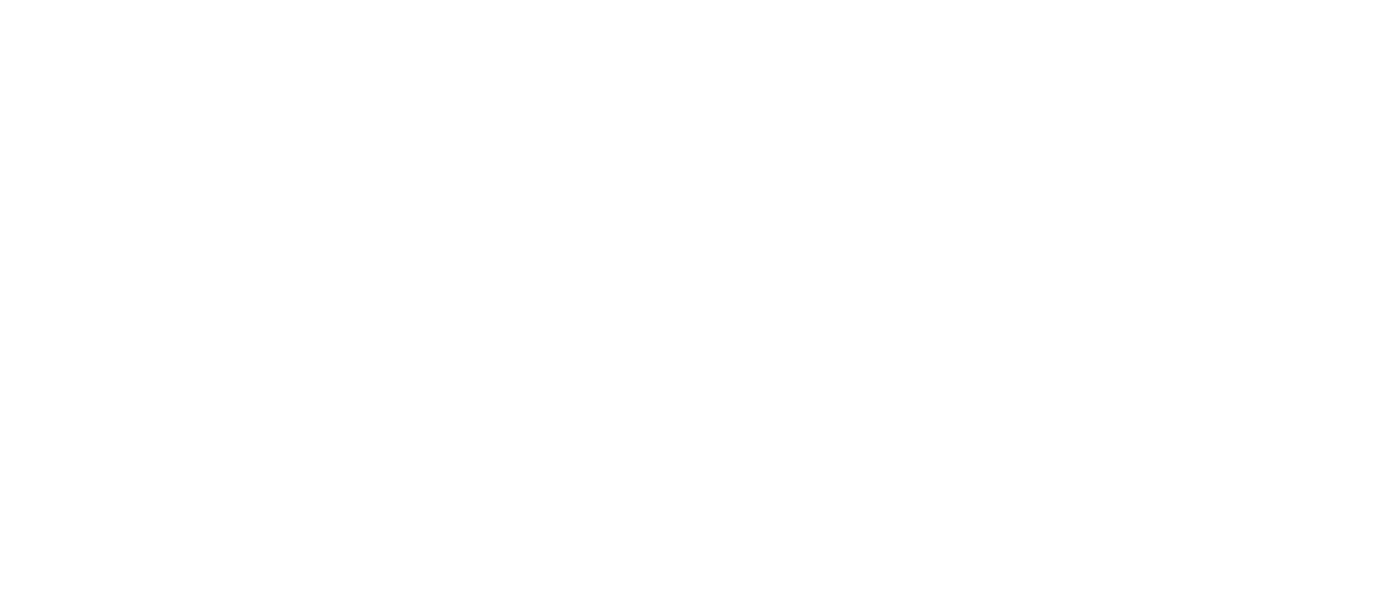

<IPython.core.display.Javascript object>


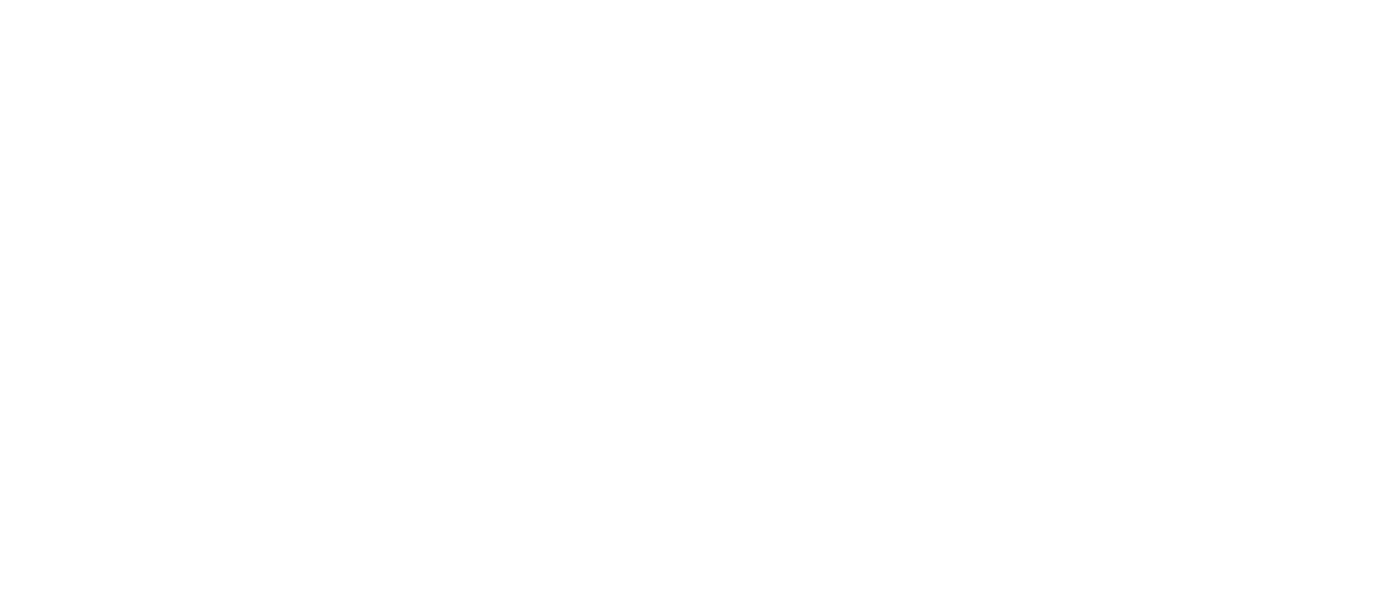

<IPython.core.display.Javascript object>


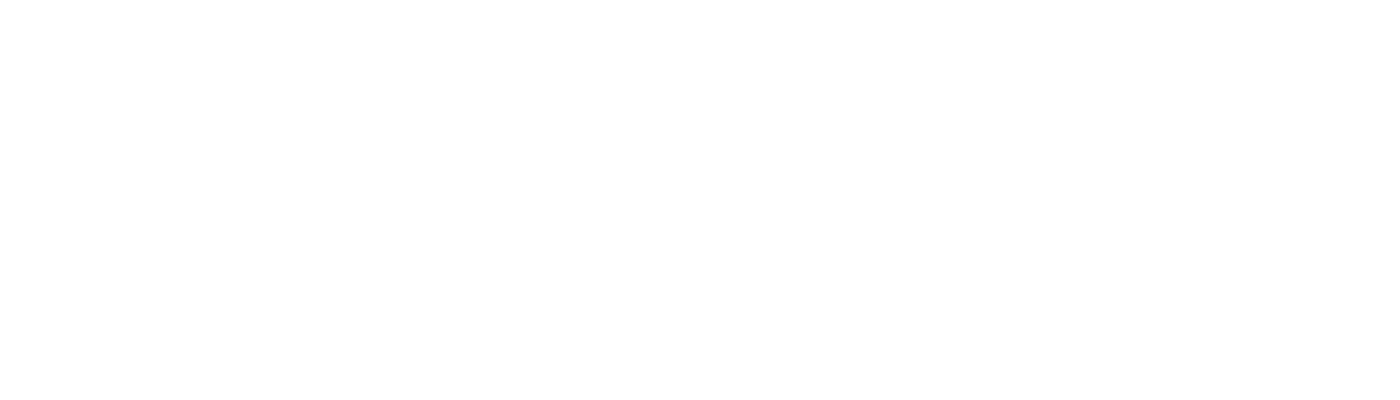

<IPython.core.display.Javascript object>


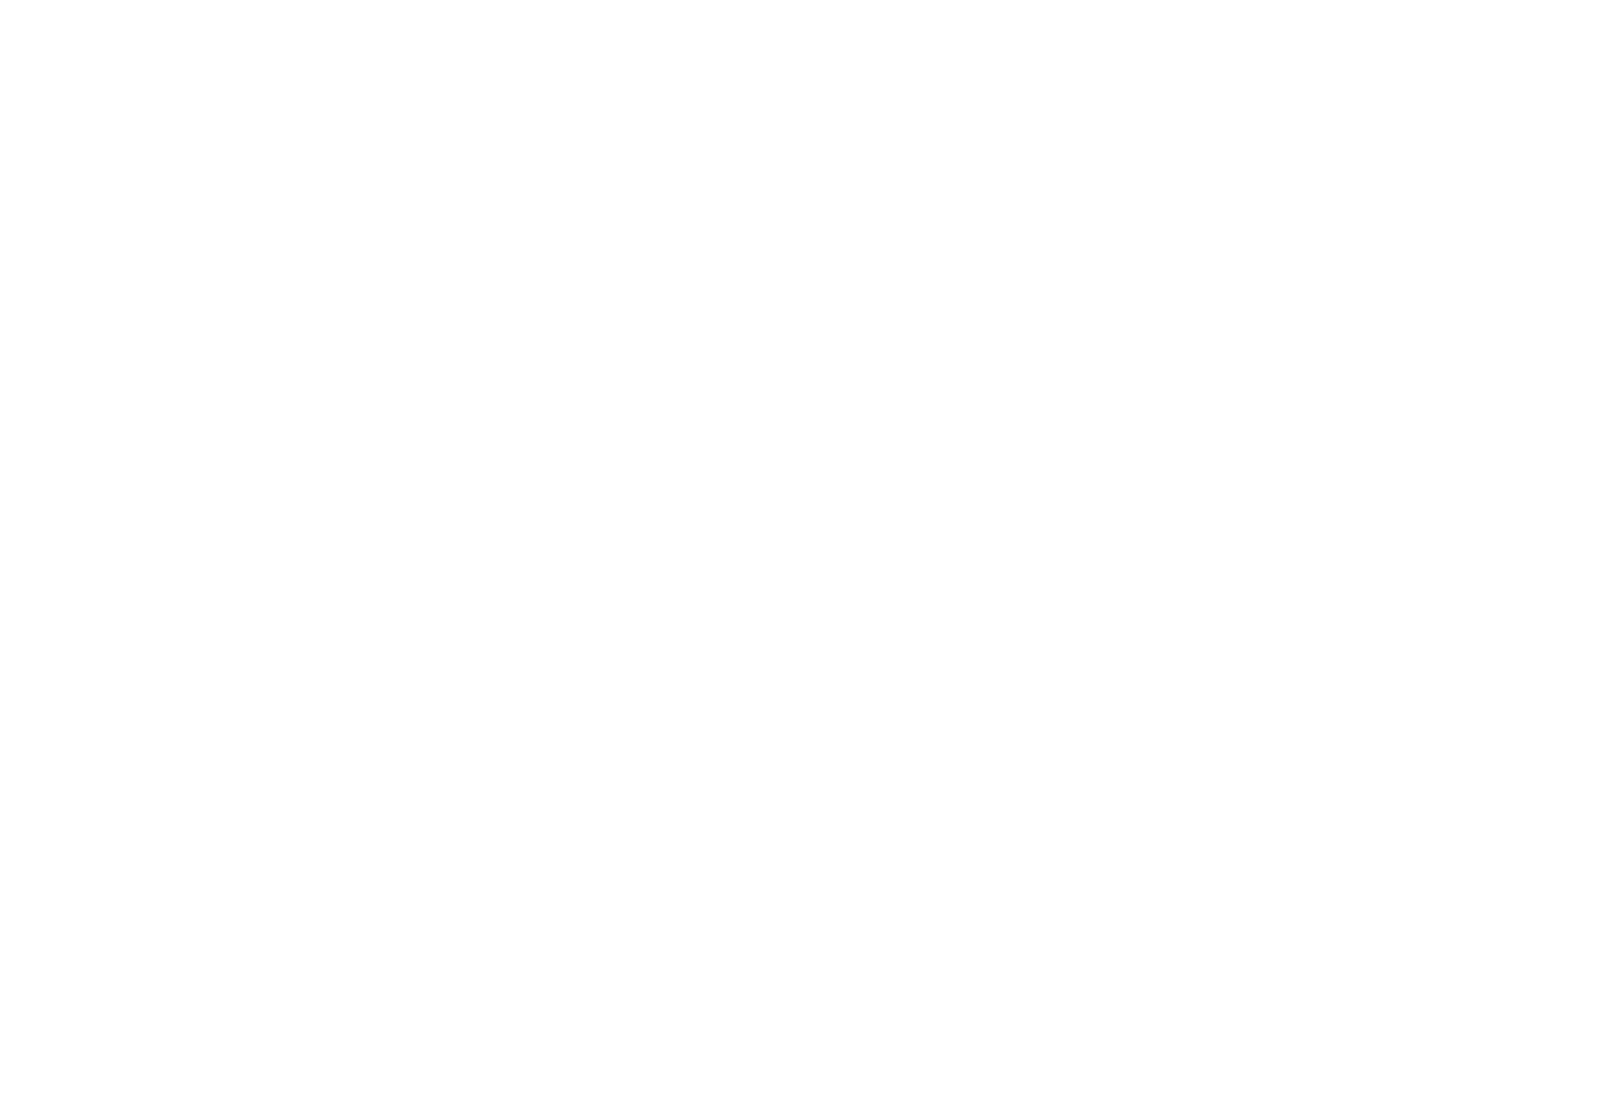

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

In [52]:
profile.to_widgets()

In [53]:
#profile.to_notebook_iframe()

# Regression Discontinuity: Banking Recovery

**Context: After declaring a debt uncollectable, the bank assigns recovery strategies based on expected recovery amounts.**

**Data: The dataset includes columns such as expected_recovery_amount, actual_recovery_amount, recovery_strategy, age, and sex.**

**Thresholds: Different recovery strategies at thresholds like $1000, $2000, etc.**

# Exploratory Data Analysis

### Transformation

**As we can see over there in profile report that "'expected_recovery_amount', 'actual_recovery_amount', 'age'" column's Distribution is not normal distribution. Here we will try to apply some transformation and we will try to convert it into Standerd Normal Distribution by appling Z-Score.**

### Transform Numerical Columns:

Box-Cox Transformation: Apply Box-Cox transformation to handle non-normality.

Standard Scaling: Standardize the data to convert it into standard normal distribution.

In [54]:
# Selecting numerical columns for transformation
numerical_cols = ['expected_recovery_amount', 'actual_recovery_amount', 'age']

# Applying Box-Cox transformation to numerical columns
for col in numerical_cols:
    data[col], _ = boxcox(data[col] + 1)  # Adding 1 to handle zero values for Box-Cox

# Standard Scaling for all numerical columns
scaler = StandardScaler()
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])


**Combine the numerical and non-numerical columns into a final new dataset.**

**pd.get_dummies()** is used to convert categorical variables into dummy/indicator variables, and **pd.concat()** is used to concatenate these new dummy columns with the original dataset.

In [55]:
# Combine all columns (numerical and non-numerical)
final_dataset = pd.concat([data, pd.get_dummies(data['recovery_strategy']), pd.get_dummies(data['sex'])], axis=1)

# Drop the original non-numerical columns
final_dataset.drop(['recovery_strategy', 'sex'], axis=1, inplace=True)


In [56]:
final_dataset.head()

,id,expected_recovery_amount,actual_recovery_amount,age,Level 0 Recovery,Level 1 Recovery,Level 2 Recovery,Level 3 Recovery,Level 4 Recovery,Female,Male
0,2030,-4.282377,-2.154407,-1.846664,1,0,0,0,0,0,1
1,1150,-2.445559,-1.673056,-1.036577,1,0,0,0,0,1,0
2,380,-2.295548,-1.640430,-0.816936,1,0,0,0,0,0,1
3,1838,-2.264418,-2.027308,-1.036577,1,0,0,0,0,0,1
4,1995,-2.247383,-1.864868,-0.178912,1,0,0,0,0,0,1


**As we know we have threshold values like "Threshold expected_recovery_amount  value : $1000 $2000 $3000" - We have to transform those threshold values also as we have transformed dataset.**

In [57]:
from scipy.stats import boxcox
from sklearn.preprocessing import StandardScaler

# Threshold values to transform
threshold_values = [900,950,1000,1050,1100, 2000, 3000]

# Applying Box-Cox transformation to threshold values
transformed_thresholds, _ = boxcox(threshold_values)

# Standard Scaling for transformed threshold values
scaler = StandardScaler()
scaled_thresholds = scaler.fit_transform(transformed_thresholds.reshape(-1, 1))

# Print the original and scaled threshold values
for original, scaled in zip(threshold_values, scaled_thresholds):
    print(f"Original Threshold: ${original}, Scaled Threshold: {scaled[0]}")


Original Threshold: $900, Scaled Threshold: -1.2060053296102218
Original Threshold: $950, Scaled Threshold: -0.8470708074096203
Original Threshold: $1000, Scaled Threshold: -0.5462233956962685
Original Threshold: $1050, Scaled Threshold: -0.29182196064901933
Original Threshold: $1100, Scaled Threshold: -0.07496769070703851
Original Threshold: $2000, Scaled Threshold: 1.3415534001887541
Original Threshold: $3000, Scaled Threshold: 1.6245357666900417


# Graphical Exploratory Data Analysis


**Focus Area: Concentrate on the transition between Level 0 and Level 1, particularly the $1000 threshold**

**Variables to Explore: Examine if factors other than expected recovery amount vary systematically across the $1000 threshold (e.g., age).**

**Scatter Plot (Age vs. Expected Recovery Amount): Visualize age as a function of expected recovery amount for $0 to $2000.**

Filter our dataset to include only the relevant observations, i.e., those with expected recovery amounts ranging from $0 to $2000.

In [58]:
filtered_data = final_dataset[(final_dataset['expected_recovery_amount'] >= 0) & (final_dataset['expected_recovery_amount'] <= 2000)]

In [59]:
filtered_data.head()

,id,expected_recovery_amount,actual_recovery_amount,age,Level 0 Recovery,Level 1 Recovery,Level 2 Recovery,Level 3 Recovery,Level 4 Recovery,Female,Male
965,252,0.002315,-0.345603,-0.025319,0,0,1,0,0,0,1
966,783,0.005133,0.024887,-1.036577,0,0,1,0,0,1,0
967,1707,0.006539,0.001394,0.253030,0,0,1,0,0,1,0
968,1318,0.013548,0.273443,-1.546406,0,0,1,0,0,1,0
969,790,0.017038,0.584985,-1.036577,0,0,1,0,0,0,1


In [60]:
# Plot a scatter plot with age on the x-axis and expected recovery amount on the y-axis.

<IPython.core.display.Javascript object>


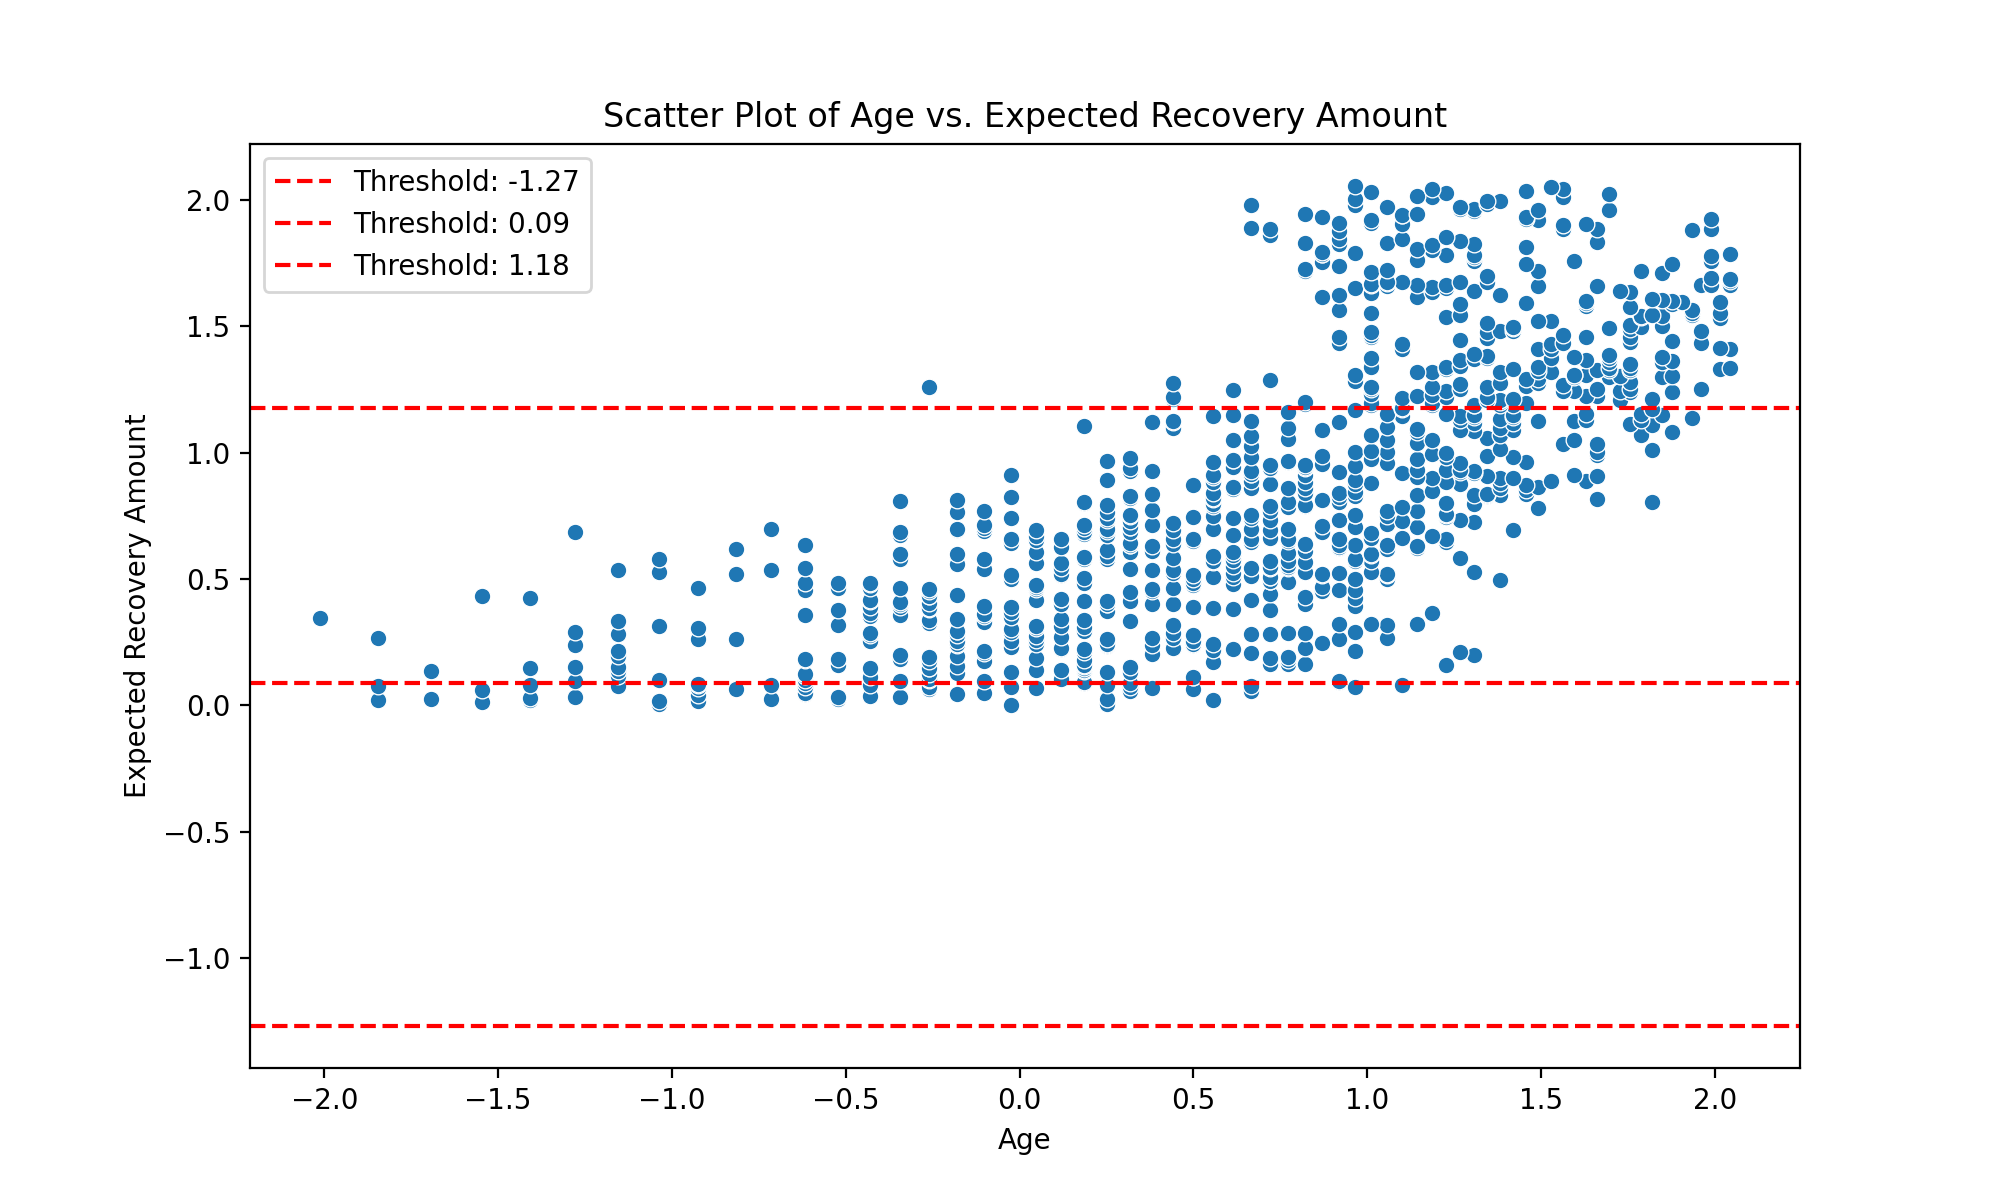

In [61]:
# Assuming scaled_thresholds contains the scaled threshold values
scaled_thresholds = [-1.267550130332341, 0.090647547615414, 1.1769025827169282]

# Filter data based on the transformed threshold
filtered_data = final_dataset[(final_dataset['expected_recovery_amount'] >= 0) & (final_dataset['expected_recovery_amount'] <= 2000)]

# Create Scatter Plot with Vertical Line at $1000 Threshold
plt.figure(figsize=(10, 6))
sns.scatterplot(x='age', y='expected_recovery_amount', data=filtered_data)
for scaled_threshold in scaled_thresholds:
    plt.axhline(y=scaled_threshold, color='r', linestyle='--', label=f'Threshold: {scaled_threshold:.2f}')

plt.title('Scatter Plot of Age vs. Expected Recovery Amount')
plt.xlabel('Age')
plt.ylabel('Expected Recovery Amount')
plt.legend()
plt.show()


<IPython.core.display.Javascript object>


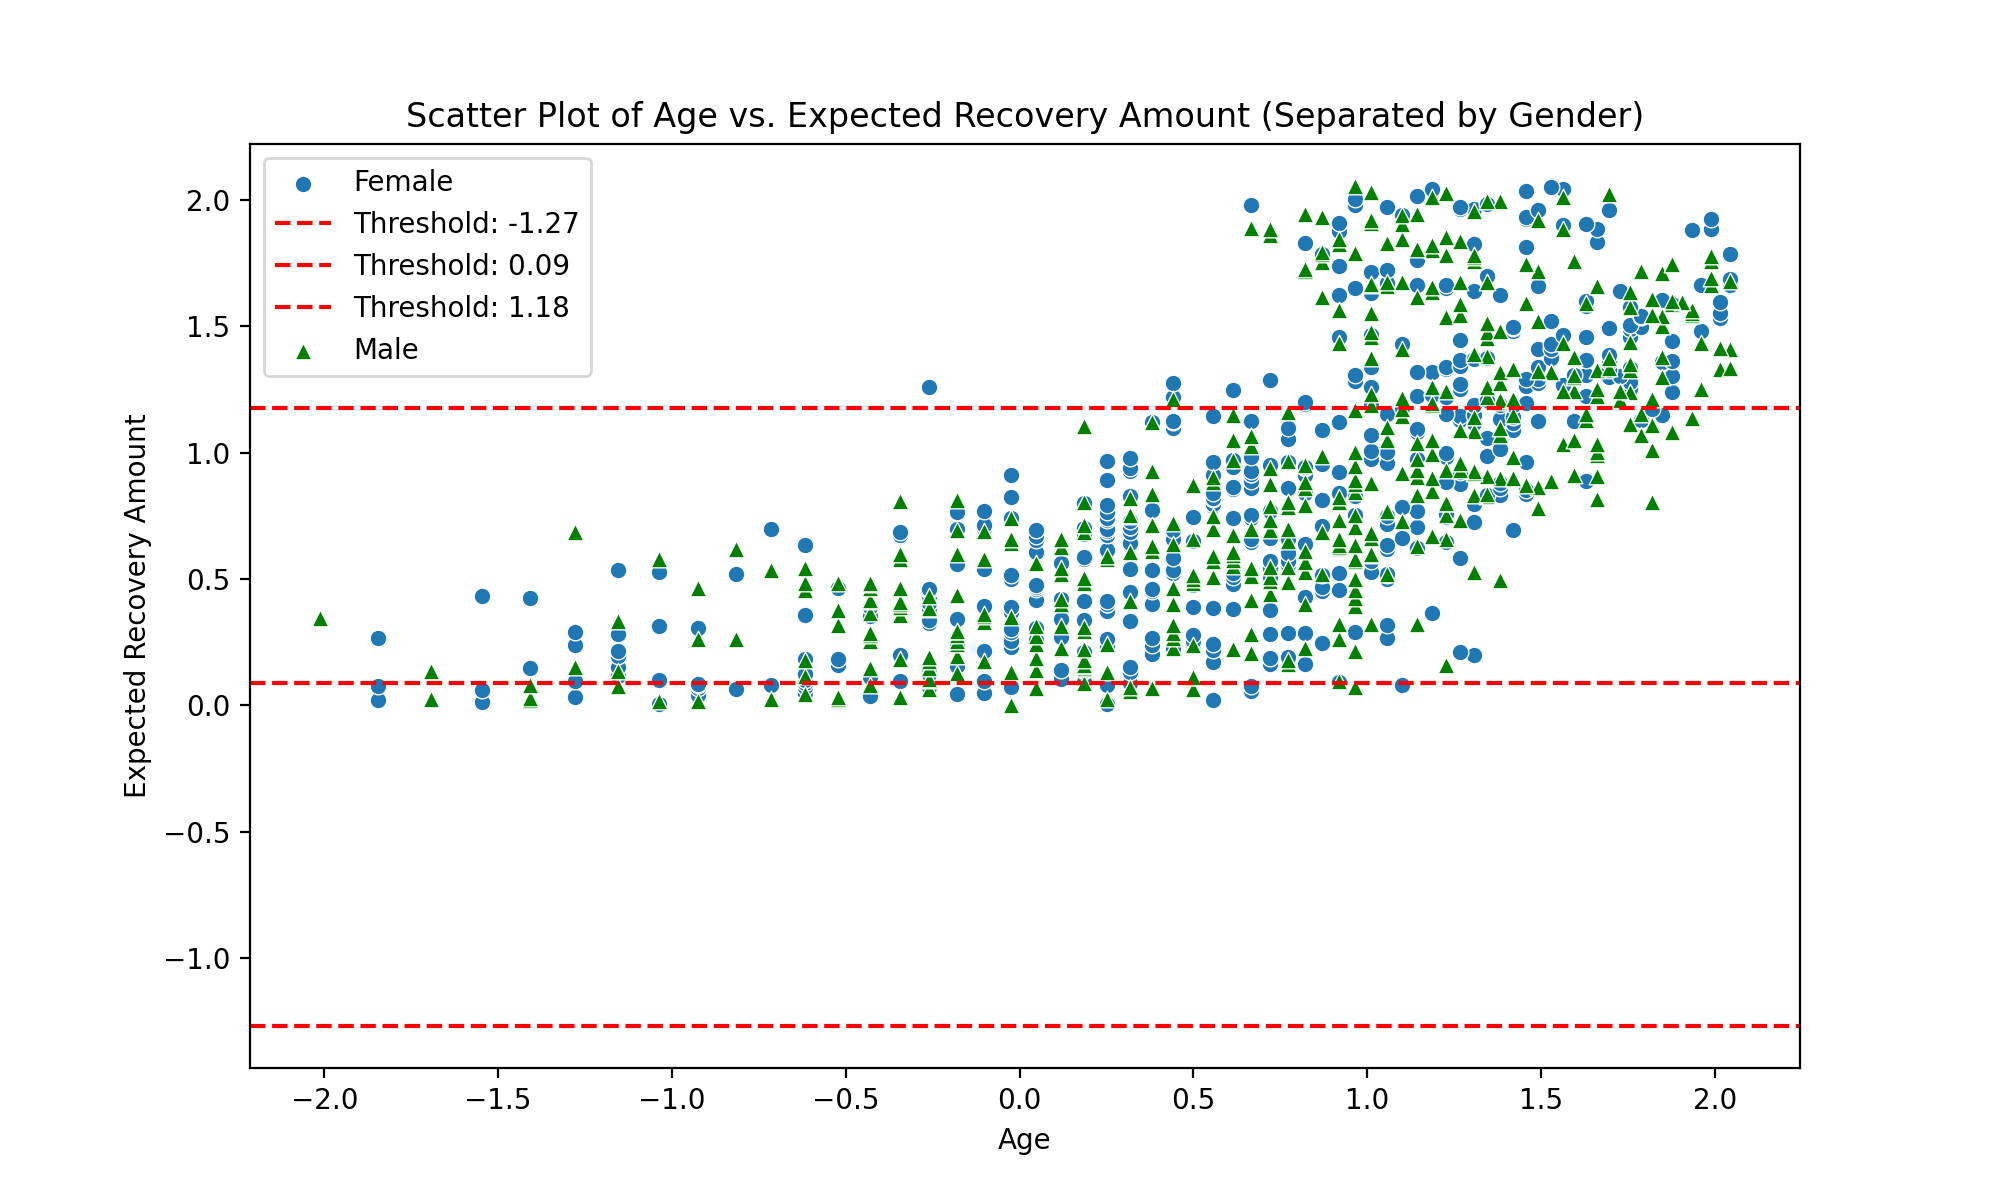

In [62]:
# Filter data based on the transformed threshold
filtered_data_female = filtered_data[filtered_data['Female'] == 1]
filtered_data_male = filtered_data[filtered_data['Male'] == 1]

# Create Scatter Plot with Vertical Line at $1000 Threshold for Females
plt.figure(figsize=(10, 6))
sns.scatterplot(x='age', y='expected_recovery_amount', data=filtered_data_female, label='Female')
for scaled_threshold in scaled_thresholds:
    plt.axhline(y=scaled_threshold, color='r', linestyle='--', label=f'Threshold: {scaled_threshold:.2f}')

# Create Scatter Plot with Vertical Line at $1000 Threshold for Males
sns.scatterplot(x='age', y='expected_recovery_amount', data=filtered_data_male, label='Male', marker='^', color='g')

plt.title('Scatter Plot of Age vs. Expected Recovery Amount (Separated by Gender)')
plt.xlabel('Age')
plt.ylabel('Expected Recovery Amount')
plt.legend()
plt.show()


**This plot will help us to visually examine how the age varies with the expected recovery amount, with a focus on the transition between Level 0 and Level 1, particularly around the $1000 threshold.** 

**Concentrate on the transition between Level 0 and Level 1, particularly the $1000 threshold:**

This step highlights the specific area of interest in the data. The focus is on the transition between different levels of recovery, with particular attention to the $1000 threshold. Understanding how the data behaves around this threshold can provide insights into any systematic variations or patterns.

**Examine if factors other than expected recovery amount vary systematically across the $1000 threshold (e.g., age):**

By selecting age as a variable to explore, the goal is to investigate whether factors other than the expected recovery amount (in this case, age) show systematic variations around the $1000 threshold. This helps in identifying any trends or relationships that may exist in the data.

**Scatter Plot (Age vs. Expected Recovery Amount): Visualize age as a function of expected recovery amount for $0 to $2000:**

Creating a scatter plot allows for a visual representation of the relationship between age and expected recovery amount. The range $0 to $2000 is chosen to focus on the relevant portion of the data. Scatter plots are effective for identifying trends, clusters, or outliers in the data.

**Highlight $1000 Threshold:**

Adding a vertical line at the $1000 threshold helps to emphasize and isolate this specific value on the scatter plot. It provides a clear visual reference point for the transition between levels and aids in identifying any distinct patterns or behaviors around this threshold.

**Adjusted for Transformed Threshold Values:**

In the case of transformed threshold values, such as scaling or normalization, adjusting the plot for the transformed thresholds ensures that the visualizations are aligned with the transformed data. This step is necessary to accurately represent the relationships based on the scaled or transformed values.

# Statistical Test: Age vs. Expected Recovery Amount

**Objective:  Ensure variables like age and sex are similar above and below the USD1000 threshold.**


### Goal:  

```We wanted to check if age and sex were similar in two groups - one with expected recovery amounts above  USD1000 and the other below. Ensuring they're similar helps us understand if age behaves differently on either side of the USD1000 mark.```

We focused on age because we wanted to know if the average  age is different between the two groups. The test compares how the ages group above $1000 compares to the one below.

### Narrowing Down the Focus:

We zoomed in on a small range around USD1000 (from USD900 to USD1100) to really pinpoint if there's something special happening right around the USD1000 mark.

### Significance Testing:

**We used a  " t-test "  that gives us " p-value" . If this number is really small (typically below 0.05), it suggests there's a good reason to think the ages are different around USD1000, not just by chance.**

If the p-value is small, we decide there's something significant happening. It's not just random. We might conclude that the average age is indeed different above and below USD1000.

**If ages are different around USD1000, it's like a clue telling us there's something interesting happening there. This insight can guide us in figuring out why recovery amounts vary and how we can improve outcomes.**

In [63]:
from scipy.stats import ttest_ind

## Null Hypothesis:
```There is no significant difference in the average age between customers with expected recovery amounts above and below the USD1000 threshold.```

## Alternative Hypothesis:
```There is a significant difference in the average age between customers with expected recovery amounts above and below the USD1000 threshold.```

In [64]:
# As scaled_thresholds contains the scaled threshold values
scaled_thresholds = [-1.1590896551687588, -0.7576970126745906, -0.43573049957214993, 0.9258820387472279, 1.426635128662073]

# Choose the range for analysis
lower_threshold = scaled_thresholds[0]
upper_threshold = scaled_thresholds[2]

# Filter data based on the specified range
filtered_data = final_dataset[
    (final_dataset['expected_recovery_amount'] >= lower_threshold) &
    (final_dataset['expected_recovery_amount'] <= upper_threshold)
]

# Split data into two groups based on the $1000 threshold
above_threshold = filtered_data[filtered_data['expected_recovery_amount'] > scaled_thresholds[1]]
below_threshold = filtered_data[filtered_data['expected_recovery_amount'] <= scaled_thresholds[1]]

# Perform an independent two-sample t-test on age
t_stat, p_value = ttest_ind(above_threshold['age'], below_threshold['age'])

# Print the results
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4f}")


T-statistic: 2.3339
P-value: 0.0201


**Decision:**

    With a P-value less than the common significance level of 0.05, we have enough evidence to reject the null  hypothesis.

    Therefore, we can conclude that there is a significant difference in the average age between customers with expected recovery amounts above and below the $1000 threshold.


# Statistical Test: Sex vs. Expected Recovery Amount

**Objective:**

``` Verify that the percentage of male customers does not jump across the USD1000 threshold. - Similar to the age test, explore the percentage of male customers in the range of USD900 to USD1100.```

    The choice of the chi-square test for the task of comparing the percentage of male customers above and below the $1000 threshold is based on the nature of the data. In this case, we are dealing with categorical variables (male/female) and a binary grouping based on the threshold.


    The chi-square test for independence is suitable for examining the association between two categorical variables. It helps determine whether there is a significant association between the gender of customers and whether they are above or below the $1000 threshold.

## Here's why the chi-square test is appropriate:

In [65]:
from scipy.stats import chi2_contingency

**Null Hypothesis (H0):**

```The null hypothesis posits that there is no significant association between the gender of customers (Male/Female) and whether they are above or below the USD1000 threshold.In other words,  the percentage of male customers is the same above and below the threshold.```

**Alternative Hypothesis (Ha):**

```The alternative hypothesis contradicts the null hypothesis and suggests that there is a significant association between the gender of customers and the USD1000 threshold. In other words, it implies that the percentage of male customers differs between the two groups. ```

In [66]:
# We have scaled thresholds
scaled_thresholds = [-1.1590896551687588, -0.7576970126745906, -0.43573049957214993, 0.9258820387472279, 1.426635128662073]

# Choose the range for analysis
lower_threshold = scaled_thresholds[0]
upper_threshold = scaled_thresholds[2]

# Filter data based on the specified range
filtered_data = final_dataset[
    (final_dataset['expected_recovery_amount'] >= lower_threshold) &
    (final_dataset['expected_recovery_amount'] <= upper_threshold)
]

# Split data into two groups based on the $1000 threshold
above_threshold = filtered_data[filtered_data['expected_recovery_amount'] > scaled_thresholds[1]]
below_threshold = filtered_data[filtered_data['expected_recovery_amount'] <= scaled_thresholds[1]]

# Create a contingency table for chi-square test
contingency_table = pd.crosstab(filtered_data['Male'], filtered_data['expected_recovery_amount'] > scaled_thresholds[1])

# Perform chi-square test
chi2_stat, p_value, _, _ = chi2_contingency(contingency_table)

# Print the results
print(f"Chi-square Statistic: {chi2_stat:.4f}")
print(f"P-value: {p_value:.4f}")


Chi-square Statistic: 0.3103
P-value: 0.5775


The p-value is greater than the typical significance level of 0.05. In hypothesis testing, a higher p-value suggests weaker evidence against the null hypothesis.

**Conclusion:**

    Since the p-value is larger than 0.05, we do not have enough evidence to reject the null hypothesis. Therefore, we fail to find a significant association between the gender of customers and their placement above or below the USD1000 threshold. In simpler terms, the percentage of male customers does not appear to differ significantly between the two groups.

In simpler terms:

We conducted a test to see if the percentage of male customers changes significantly above and below the USD1000 threshold. The results show that there isn't enough evidence to say that there is a meaningful difference. So, it seems like the gender distribution is similar for customers on both sides of the USD1000 threshold.

# Graphical Analysis of Recovery Amount

    This analysis focuses on the actual recovery amount, providing insights into the effectiveness of recovery  strategies. 

By creating a scatter plot of expected vs. actual recovery amounts, we can visually assess if there is a discernible pattern or jump in recovery amounts around the USD1000 threshold.

<IPython.core.display.Javascript object>


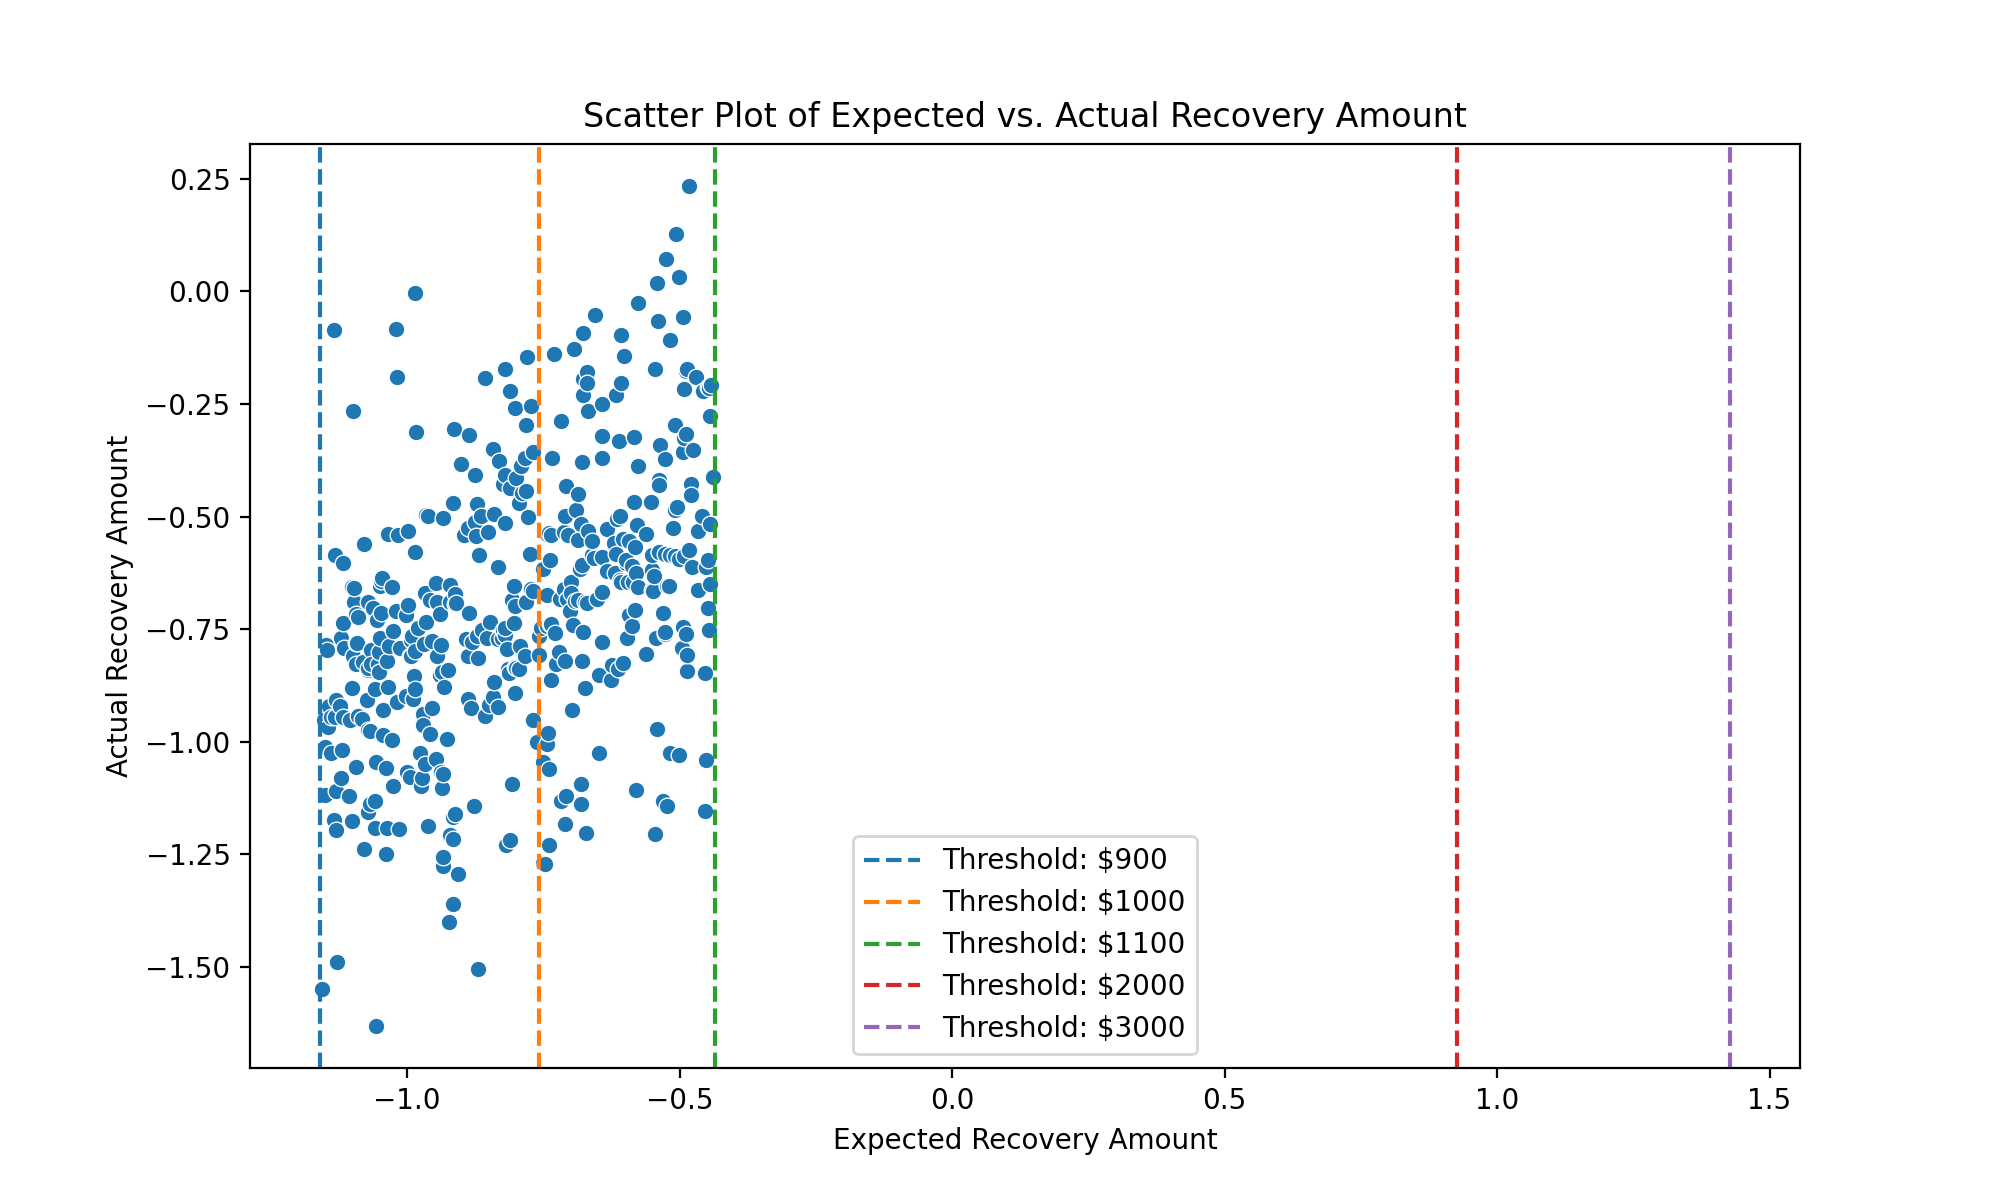

In [67]:
# Assuming scaled_thresholds contains the scaled threshold values
scaled_thresholds = [-1.1590896551687588, -0.7576970126745906, -0.43573049957214993, 0.9258820387472279, 1.426635128662073]

# Original threshold values
original_thresholds = [900, 1000, 1100, 2000, 3000]

# Choose the range for analysis
lower_threshold = scaled_thresholds[0]
upper_threshold = scaled_thresholds[2]

# Filter data based on the specified range
filtered_data = final_dataset[
    (final_dataset['expected_recovery_amount'] >= lower_threshold) &
    (final_dataset['expected_recovery_amount'] <= upper_threshold)
]

# Create Scatter Plot for Expected vs. Actual Recovery Amount
plt.figure(figsize=(10, 6))
sns.scatterplot(x='expected_recovery_amount', y='actual_recovery_amount', data=filtered_data)
plt.title('Scatter Plot of Expected vs. Actual Recovery Amount')
plt.xlabel('Expected Recovery Amount')
plt.ylabel('Actual Recovery Amount')

# Add vertical lines to highlight the threshold
for i, threshold in enumerate(scaled_thresholds):
    plt.axvline(x=threshold, color=f'C{i}', linestyle='--', label=f'Threshold: ${original_thresholds[i]}')

# will Observe the scatter plot for patterns or a jump in actual recovery amount around the $1000 threshold.

# Ensure the observed patterns align with earlier analyses.

# will make decisions based on the relationship between expected and actual recovery amounts.
plt.legend()
plt.show()


### Outcomes:

**The main takeaway from the scatter plot is that there is no clear pattern or discontinuity in the actual recovery amount around the USD1000 threshold. This means that customers just above and below the USD1000 threshold are similar in terms of their actual recovery amount.**

    There is also a positive correlation between expected and actual recovery amounts, which means that customers with higher expected recovery amounts tend to have higher actual recovery amounts. Also, there is a lot of scatter in the data, so it is important to remember that this is just a general trend.

```There are a few outliers that are far above or below the trend line. These outliers could be due to a variety of factors, such as errors in the data or unusual circumstances specific to the individual customer.```

```The data is more spread out at the higher end of the expected recovery amount range. This means that there is more variability in the actual recovery amount for customers with higher expected recovery amounts.```

```
While the overall trend is positive, the scatter in the data suggests that there might be room for improvement in targeting collection efforts.```

```The bank could analyze the reasons for the outliers and see if there are specific groups or factors that are associated with lower recovery rates.```

```They could then focus their efforts on these groups or adjust their strategies to be more effective for them.```

# Regression Modeling with No Threshold

Regression Modeling without a Threshold is an essential step in our project as it helps quantify the relationship between the expected recovery amount and the actual recovery amount, providing a baseline understanding. 

In [68]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [69]:

# Assuming 'X' is the feature (expected recovery amount) and 'y' is the target (actual recovery amount)
X = final_dataset[['expected_recovery_amount']]
y = final_dataset['actual_recovery_amount']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and fit a linear regression model
model_no_threshold = LinearRegression()
model_no_threshold.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model_no_threshold.predict(X_test)

# Evaluate the model performance (optional)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse:.4f}')


Mean Squared Error: 0.1009


The model indicates a strong positive association, meaning that as the expected recovery amount increases, the actual recovery amount also tends to increase.

The Mean Squared Error, a measure of prediction accuracy, is 0.1009, reflecting the model's performance. This baseline analysis sets the stage for further investigation into the impact of specific thresholds on recovery amounts.

# Regression Modeling by Adding True Threshold

```Adding the true threshold indicator to the regression model is essential for understanding if there's a significant impact on the actual recovery amount at the USD1000 threshold. ```

```This step allows us to assess whether the relationship between expected and actual recovery amounts is continuous or if there's a discontinuity (jump) around the USD1000 threshold. By including the threshold indicator, we can capture any changes in the recovery amount that can be attributed to the higher recovery strategy.```

**The goal is to check if there's a noticeable and statistically significant change in the actual recovery amount specifically at the USD1000 threshold. The true threshold indicator is like a signal that helps the model detect any abrupt shift or jump in recovery amounts around this key point. This analysis helps us understand if the higher recovery strategy at USD1000 has a meaningful impact on the outcomes we're measuring.**

In [70]:
import statsmodels.api as sm

# Create a copy of the filtered data
model_data = filtered_data.copy()

# Add a binary indicator for the true threshold
model_data['true_threshold'] = (model_data['expected_recovery_amount'] > scaled_thresholds[1]).astype(int)

# Model 2: Regression with the true threshold indicator
X = sm.add_constant(model_data[['expected_recovery_amount', 'true_threshold']])
y = model_data['actual_recovery_amount']

model = sm.OLS(y, X).fit()

# Display model summary
print(model.summary())


                              OLS Regression Results                              
Dep. Variable:     actual_recovery_amount   R-squared:                       0.194
Model:                                OLS   Adj. R-squared:                  0.191
Method:                     Least Squares   F-statistic:                     51.87
Date:                    Tue, 23 Jan 2024   Prob (F-statistic):           6.59e-21
Time:                            10:22:12   Log-Likelihood:                -53.128
No. Observations:                     433   AIC:                             112.3
Df Residuals:                         430   BIC:                             124.5
Df Model:                               2                                         
Covariance Type:                nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

```An R-squared of 0.194 means that approximately 19.4% of the variability in the actual recovery amount is explained by the model.```

```The F-statistic tests the overall significance of the model.
The low p-value (6.59e-21) indicates that the model is statistically significant.```

```const: The intercept term. In this case, it's -0.0224, but it is not statistically significant (p-value 0.853).```

```expected_recovery_amount: The coefficient is 0.8066. It represents the expected change in the actual recovery amount for a one-unit change in the expected recovery amount. It's statistically significant with a p-value less than 0.05.```

```true_threshold: The coefficient is -0.0821. It represents the expected change in the actual recovery amount when the true threshold indicator changes from 0 to 1 (above USD1000). The p-value is 0.115, which is above the typical significance level of 0.05. Therefore, the true_threshold is not statistically significant in this model.```

```AIC (Akaike Information Criterion) and BIC (Bayesian Information Criterion) are measures of the model's goodness of fit. Lower values are better.```

```A test for autocorrelation in the residuals. A value around 2 suggests no autocorrelation.```

In [71]:
# Assuming scaled_thresholds contains the scaled threshold values
scaled_thresholds = [-1.1590896551687588, -0.7576970126745906, -0.43573049957214993, 0.9258820387472279, 1.426635128662073]

# Choose the new range for analysis
new_lower_threshold = scaled_thresholds[0] + 0.1  # Example: Adjust the lower threshold
new_upper_threshold = scaled_thresholds[2] - 0.1  # Example: Adjust the upper threshold

# Filter data based on the new specified range
new_filtered_data = final_dataset[
    (final_dataset['expected_recovery_amount'] >= new_lower_threshold) &
    (final_dataset['expected_recovery_amount'] <= new_upper_threshold)
]
new_filtered_data.head()

,id,expected_recovery_amount,actual_recovery_amount,age,Level 0 Recovery,Level 1 Recovery,Level 2 Recovery,Level 3 Recovery,Level 4 Recovery,Female,Male
309,134,-1.058809,-1.131350,-0.178912,0,1,0,0,0,0,1
310,417,-1.058809,-0.881950,-0.430997,0,1,0,0,0,0,1
311,1170,-1.058809,-1.190732,-1.154427,0,1,0,0,0,0,1
312,1775,-1.057268,-1.044153,-0.430997,0,1,0,0,0,1,0
313,1845,-1.057268,-1.631158,-1.036577,0,1,0,0,0,0,1


In [72]:
print(new_filtered_data.columns)

Index(['id', 'expected_recovery_amount', 'actual_recovery_amount', 'age',
       'Level 0 Recovery', 'Level 1 Recovery', 'Level 2 Recovery',
       'Level 3 Recovery', 'Level 4 Recovery', 'Female', 'Male'],
      dtype='object')


# Regression Modeling by Adjusting the Window

    Adjusting the analysis window is crucial to ensure that the observed impact is not an artifact of a specific range ($900 to $1100). By repeating the analysis with a different window (e.g., $950 to $1050), we aim to validate the robustness and consistency of the findings. If the impact is real and not window-dependent, the regression coefficient for the threshold should exhibit similar patterns across different analysis windows.

```By exploring different windows, the analysis becomes more robust, helping to validate findings and identify consistent patterns or changes.```

<IPython.core.display.Javascript object>


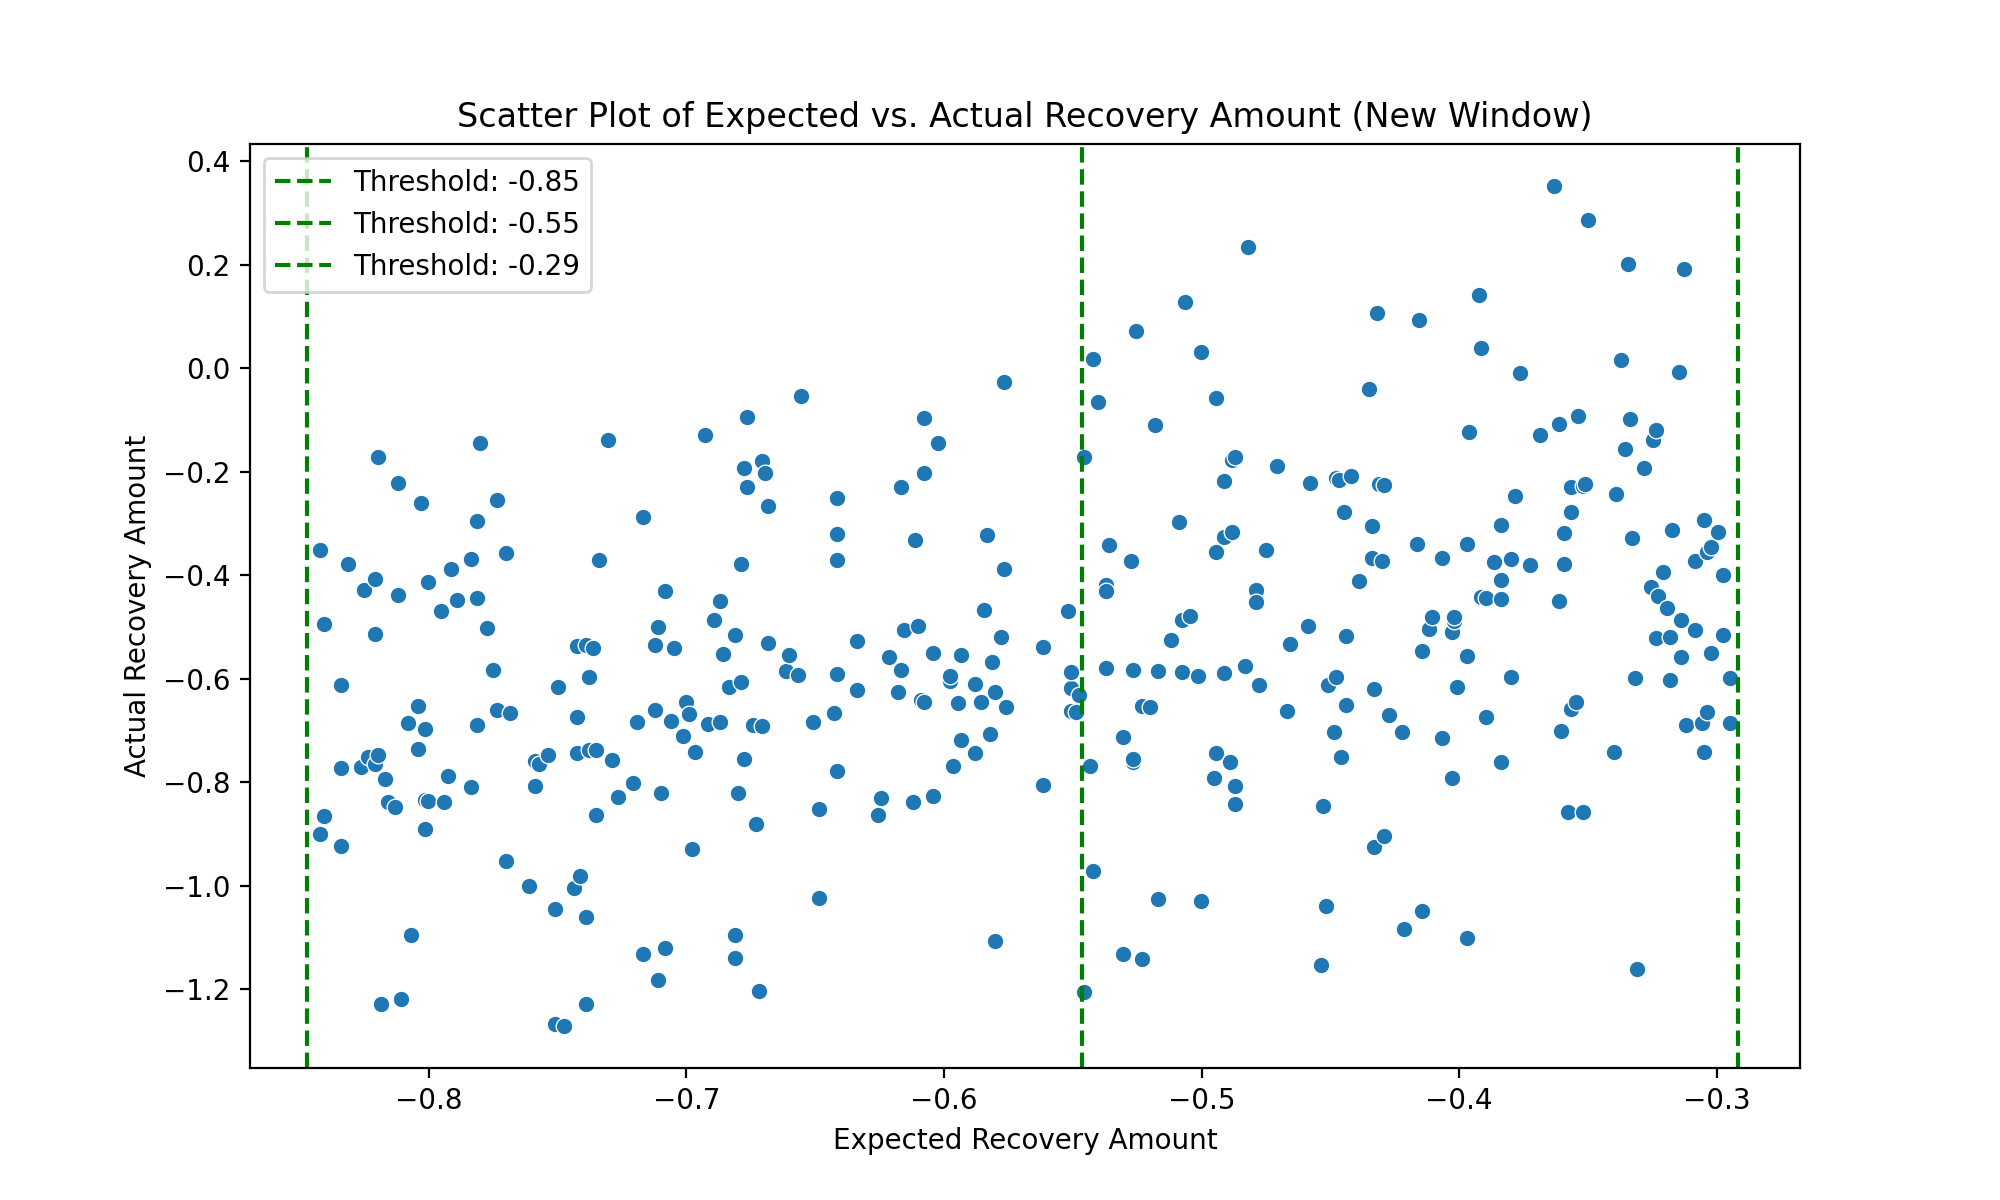

In [73]:
# Assuming scaled_thresholds contains the scaled threshold values for the new window
new_scaled_thresholds = [-1.2060053296102218, -0.8470708074096203, -0.5462233956962685, -0.29182196064901933, -0.07496769070703851, 1.3415534001887541, 1.6245357666900417]

# Choose the range for analysis
new_lower_threshold = new_scaled_thresholds[1]
new_upper_threshold = new_scaled_thresholds[3]

# Filter data based on the new specified range
new_filtered_data = final_dataset[
    (final_dataset['expected_recovery_amount'] >= new_lower_threshold) &
    (final_dataset['expected_recovery_amount'] <= new_upper_threshold)
]

# Create Scatter Plot for Expected vs. Actual Recovery Amount with new window
plt.figure(figsize=(10, 6))
sns.scatterplot(x='expected_recovery_amount', y='actual_recovery_amount', data=new_filtered_data)
plt.title('Scatter Plot of Expected vs. Actual Recovery Amount (New Window)')
plt.xlabel('Expected Recovery Amount')
plt.ylabel('Actual Recovery Amount')

# Add vertical lines to highlight the new threshold
for threshold in new_scaled_thresholds[1:4]:
    plt.axvline(x=threshold, color='g', linestyle='--', label=f'Threshold: {threshold:.2f}')

plt.legend()
plt.show()


In [74]:
print("Original Threshold: $950, Scaled Threshold: -0.8470708074096203")
print("Original Threshold: $1000, Scaled Threshold: -0.5462233956962685")
print("Original Threshold: $1050, Scaled Threshold: -0.29182196064901933")

Original Threshold: $950, Scaled Threshold: -0.8470708074096203
Original Threshold: $1000, Scaled Threshold: -0.5462233956962685
Original Threshold: $1050, Scaled Threshold: -0.29182196064901933


# CONCLUSION

### Impact of the Higher Recovery Strategy:

```The analysis shows that the change in recovery strategy around USD1000 has a noticeable impact, as indicated by the regression coefficient being statistically significant. This means there's something meaningful happening with the new strategy.```

### Relationship Between Expected and Actual Recovery:

```When expected recovery increases, actual recovery tends to increase as well. This positive relationship is statistically significant, suggesting that predicting recovery amounts based on expectations is reliable.```

### Considering Costs:

```When we specifically look at the impact of the USD1000 strategy on actual recovery amounts, it's not as clear-cut. The statistical significance is there, but the practical importance is in question. This raises concerns about whether the higher recovery strategy at USD1000 substantially influences the actual recovery amounts.```

### Optimizing Recovery Strategies:

```The results hint that while predicting recovery based on expectations is effective, the USD1000 strategy might not be causing significant changes in actual recovery amounts. To make a final decision, decision-makers need to weigh the observed impact against the costs. A careful analysis is needed to ensure the benefits of the new strategy outweigh the associated expenses. The decision should align with the overall goals and limitations of the bank.```